<a href="https://colab.research.google.com/github/husseinfawaz20/QoT/blob/main/QoT_Regression_Samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing Libraries**

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.api import OLS
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from numpy import mean
from numpy import absolute
from numpy import sqrt
import xgboost as xgb
from collections import OrderedDict
import time
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
!pip install catboost
!pip install shap

import shap
import shap.plots
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.6 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#**Read Dataset +  Train/Test**

In [38]:
df = pd.read_csv('DS_LPLevel_10100_Het_CFEGN_v3.csv')
target = 'Lightpath GSNR'
# df.head()
# df.describe()
# df.info()
# df.shape

In [39]:
X = df.drop([target], axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
num_data_points = df.shape[0]
num_features = X.shape[1]

In [40]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

#**Util Functions**

##**Setters and Getters**

In [41]:
def saveResults(y_test,y_pred,index,nb_features,tt,it,nb_splits):
  r2 = float(format((r2_score(y_test,y_pred)),'.3f'))
  rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)),'.3f'))
  mae = float(format((mean_absolute_error(y_test , y_pred)),'.3f'))

  average_it,max_it,min_it = it;
  average_it=format(average_it,'.3f')
  max_it=format(max_it,'.3f')
  min_it=format(min_it,'.3f')

  dt = pd.DataFrame({'type': [index],'rmse': [rmse], 'mae': [mae], 'r2' : [r2],'nb_features':[nb_features],'training time (s)':[tt],'average inference time/data point (ms)':[average_it],'max inference time/data point (ms)':[max_it],'min inference time/data point (ms)':[min_it],'nb of splits':[nb_splits]})
  if os.path.isfile('results.csv'):
    dt.to_csv('results.csv',mode="a", header=False)
  else:
        dt.to_csv('results.csv')
  get_results()

In [42]:
def addResults(rmse,mae,r2,index,nb_features,tt,it):
  if len(it) == 3:
      avg,max,min = it
      dt = pd.DataFrame({'type': [index],'rmse': [rmse], 'mae': [mae], 'r2' : [r2],'nb_features':[nb_features],'training time':[tt],'average inference time/data point':[avg],'max inference time/data point':[max],'min inference time/data point':[min]})
  else:
    dt = pd.DataFrame({'type': [index],'rmse': [rmse], 'mae': [mae], 'r2' : [r2],'nb_features':[nb_features],'training time':[tt],'average inference time/data point':[it],'max inference time/data point':['-'],'min inference time/data point':['-']})
  if os.path.isfile('results.csv'):
    dt.to_csv('results.csv',mode="a", header=False)
  else:
        dt.to_csv('results.csv')

In [43]:
def get_results():
  data = pd.read_csv('results.csv')
  return data.iloc[:,-10:]

In [44]:
def get_features():
  data = pd.read_csv('selected_features.csv')
  return data.iloc[:,-3:]

In [45]:
import csv

def save_features(feature_selection_types,selected_features):
  file_exists = os.path.exists('selected_features.csv')
  with open('selected_features.csv', mode='a', newline='') as file:
      writer = csv.writer(file)
      if not file_exists:
          writer.writerow(['Feature_Selection_Method','Nb_Features', 'Selected_Features'])
      for idx, selected_feature_list in enumerate([selected_features]):
          method_name = feature_selection_types
          nb_features = len(selected_features)
          selected_features_str = ', '.join(selected_feature_list)
          writer.writerow([method_name, nb_features,selected_features_str])

In [46]:
def get_tuned_params():
  data = pd.read_csv('tuned_params.csv')
  return data.iloc[:,-3:]

In [47]:
import csv

def save_tuning_params(feature_selection_types,tuned_params):
  file_exists = os.path.exists('tuned_params.csv')
  with open('tuned_params.csv', mode='a', newline='') as file:
      writer = csv.writer(file)
      if not file_exists:
          writer.writerow(['Feature_Selection_Method','Nb_Params', 'Selected_Params'])
      for idx, selected_feature_list in enumerate([tuned_params]):
          method_name = feature_selection_types
          nb_params = len(tuned_params)
          writer.writerow([method_name, nb_params,tuned_params])

In [48]:
def calc_inference_time(model,data_points=X.to_numpy(),flag='fit'): #flag=0 means already performed .fit so gives avg,max,min else gives avg only
  if flag=='no_fit' :
    model.fit(X_train,y_train)

  inference_times = []
  for data_point in data_points:
          start_time = time.time()
          prediction = model.predict(data_point.reshape(1, -1))
          end_time = time.time()
          inference_time = (end_time - start_time) * 1000   # Convert to milliseconds
          inference_times.append(inference_time)

  average_inference_time = np.mean(inference_times)
  max_inference_time = np.max(inference_times)
  min_inference_time = np.min(inference_times)
  return average_inference_time,max_inference_time, min_inference_time

In [49]:
def features_summary () :
    model_features = pd.read_csv("selected_features.csv")

    selected_features_list = [set(feature.strip() for feature in features.split(",")) for features in model_features["Selected_Features"]]

    features_dict = {}
    for idx, features in enumerate(selected_features_list):
        for feature in features:
            if feature not in features_dict:
                features_dict[feature] = [0] * len(model_features)
            features_dict[feature][idx] = 1

    selected_features_df = pd.DataFrame(features_dict)

    selected_features_df.insert(0, "Method", model_features["Feature_Selection_Method"])

    plt.figure(figsize=(10,6))
    sns.heatmap(selected_features_df.set_index("Method"), cmap="Blues", cbar=False, xticklabels="auto", yticklabels="auto")
    plt.ylabel("Methods")
    plt.yticks(rotation=0)
    plt.xlabel("Selected Features")
    plt.title("Selected Features after Different Feature Selection Methods")
    plt.tight_layout()
    plt.savefig("selected_features_heatmap.png")
    plt.show()


##**Train Feature Selection Features + Hypertuning**

In [50]:
def train_selected_features(selected_features,fs,model='xgb'):
  X_train_selected = X_train[selected_features]
  params={'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8,
       'reg_alpha':0.5,'reg_lambda':0.5,'gamma':0.2 }
  if model=='lgb':
      model_selected = LGBMRegressor()
  elif model == 'xgb':
    model_selected = XGBRegressor(**params)
  nb_features = len(selected_features)
  save_features(fs,selected_features)

  start_time = time.time()
  model_selected.fit(X_train_selected, y_train)
  end_time = time.time()

  training_time = end_time - start_time
  inference_time_per_data_point = calc_inference_time(model_selected,data_points=X[selected_features].to_numpy())

  X_test_selected = X_test[selected_features]
  y_pred =  model_selected.predict(X_test_selected)
  if model=='lgb':
        nb_splits = calculate_lgb_splits(model)
  elif model == 'xgb':
        nb_splits = calculate_xgb_splits(model)

  saveResults(y_test,y_pred,f'Feature Selection method: {fs}',nb_features,training_time,inference_time_per_data_point,nb_splits)
  return get_results()

In [51]:
def train_selected_features_with_hypertuning(selected_features,fs,model='xgb'):
  if model=='lgb':
    return train_lgb_hypertune(selected_features,fs)
  elif model == 'xgb':
    return train_xgb_hypertune(selected_features,fs)
  elif model == 'cbr':
    return train_cb_hypertune(selected_features,fs)

In [52]:
def train_xgb_hypertune (selected_features,fs_type) :
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    save_features(fs_type,selected_features)
    nb_features = len(selected_features)

    xgb = XGBRegressor()
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    params = {
                  'objective':['reg:squarederror'],
                  'learning_rate': [0.01,0.1], #0.1
                  'max_depth': [3,6,8],#3
                  'min_child_weight': [1,3],#1
                  'subsample': [0.3,0.8], #0.8
                  'n_estimators': [300,500], #500
                  'reg_alpha': [0.1, 0.5],
                  'reg_lambda': [0.1, 0.5],
                  'gamma': [ 0.1, 0.2],
    }

    grid_search = GridSearchCV(xgb, params, cv=cv,scoring = 'r2')
    grid_search.fit(X_train_selected, y_train)
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    save_tuning_params(fs_type,best_params)
    best_reg = grid_search.best_estimator_

    best_xgb_model = XGBRegressor(**best_params)

    start_time = time.time()
    best_xgb_model.fit(X_train_selected, y_train)
    end_time = time.time()

    training_time = end_time - start_time
    inference_time_per_data_point = calc_inference_time(best_xgb_model,data_points=X[selected_features].to_numpy())

    y_pred = best_xgb_model.predict(X_test_selected)
    nb_splits = calculate_xgb_splits(best_xgb_model)
    saveResults(y_test,y_pred,fs_type,nb_features,training_time,inference_time_per_data_point,nb_splits)
    return get_results()

In [53]:
def train_lgb_hypertune (selected_features,fs_type) :
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    save_features(fs_type,selected_features)
    nb_features = len(selected_features)

    lgb = LGBMRegressor()
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    params = {
        'learning_rate': [0.05, 0.1], #0.05
        'n_estimators': [100,300,500], #500
        'max_depth': [3,6,8], #6
        'min_child_samples': [10,15],#10
    }


    grid_search = GridSearchCV(lgb, params, cv=cv,scoring = 'r2')
    grid_search.fit(X_train_selected, y_train)
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    save_tuning_params(fs_type,best_params)

    best_lgb_model = LGBMRegressor(**best_params)

    start_time = time.time()
    best_lgb_model.fit(X_train_selected, y_train)
    end_time = time.time()

    training_time = end_time - start_time
    inference_time_per_data_point = calc_inference_time(best_lgb_model,data_points=X[selected_features].to_numpy())

    best_reg = grid_search.best_estimator_

    y_pred = best_lgb_model.predict(X_test_selected)
    nb_splits = calculate_lgb_splits(best_lgb_model)
    saveResults(y_test,y_pred,fs_type,nb_features,training_time,inference_time_per_data_point,nb_splits)
    return get_results()

In [54]:
def train_cb_hypertune (selected_features,fs_type) :
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    save_features(fs_type,selected_features)
    nb_features = len(selected_features)

    params = {
        'iterations': [300,500], #1000
        'learning_rate': [0.03,0.1], #0.03
        'depth': [3, 6,8], #6
        'l2_leaf_reg': [0.2,0.5], #0.5
    }
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cbr = CatBoostRegressor()
    grid_search = GridSearchCV(estimator=cbr, param_grid=params, scoring='neg_mean_squared_error', cv=cv)


    grid_search = GridSearchCV(cbr, params, cv=cv,scoring = 'r2')
    grid_search.fit(X_train_selected, y_train)
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    save_tuning_params(fs_type,best_params)

    best_cb_model = CatBoostRegressor(**best_params)

    start_time = time.time()
    best_cb_model.fit(X_train_selected, y_train)
    end_time = time.time()

    training_time = end_time - start_time
    inference_time_per_data_point = calc_inference_time(best_cb_model,data_points=X[selected_features].to_numpy())

    y_pred = best_cb_model.predict(X_test_selected)
    nb_splits = calculate_cb_splits(best_cb_model)

    saveResults(y_test,y_pred,fs_type,nb_features,training_time,inference_time_per_data_point,nb_splits)
    return get_results()

In [72]:
def train_prepared_model (selected_features,params,fs_type,fs_message) :
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    save_features(fs_message,selected_features)
    nb_features = len(selected_features)

    if fs_type == 'cbr':
      model = CatBoostRegressor(**params)
    if fs_type == 'xgb':
      model = XGBRegressor(**params)
    if fs_type == 'lgb':
      model = LGBMRegressor(**params)

    start_time = time.time()
    model.fit(X_train_selected, y_train)
    end_time = time.time()

    training_time = end_time - start_time
    inference_time_per_data_point = calc_inference_time(model,data_points=X[selected_features].to_numpy())

    y_pred = model.predict(X_test_selected)

    if fs_type == 'cbr':
      nb_splits = calculate_cb_splits(model)
    if fs_type == 'xgb':
      nb_splits = calculate_xgb_splits(model)
    if fs_type == 'lgb':
      nb_splits = calculate_lgb_splits(model)

    saveResults(y_test,y_pred,fs_message,nb_features,training_time,inference_time_per_data_point,nb_splits)
    return get_results()

##**Complexity and Number of splits**

In [56]:
def calculate_xgb_splits (xgb) :
    booster = xgb.get_booster()
    trees_strings = booster.get_dump(dump_format='text')
    total_splits = 0
    for tree_string in trees_strings:
      n_nodes = len(tree_string.split('\n')) - 1
      n_leaves = tree_string.count('leaf')
      total_splits += n_nodes - n_leaves
    print('total_splits:',total_splits)
    return total_splits

In [57]:
def calculate_lgb_splits (lgb) :
    booster = lgb.booster_
    trees_strings = booster.dump_model()

    total_splits = 0
    for tree_string in trees_strings['tree_info']:
        n_nodes = tree_string['num_leaves'] - 1
        total_splits += n_nodes

    print("Total number of splits:", total_splits)
    return total_splits

In [58]:
def calculate_cb_splits (catboost_model) :

    total_splits = 0
    tree_params = ['depth']  # Adjust this list based on available tree-related parameters

    for param in tree_params:
        total_splits += catboost_model.get_all_params()[param] * catboost_model.get_all_params()['iterations']

    print("Estimated total number of splits:", total_splits)
    return total_splits

In [59]:
def calculate_splits (regressor) : #rf - gb
    estimators = regressor.estimators_

    total_splits = 0
    # for estimator in estimators[0]:
    #     n_nodes = estimator.tree_.node_count
    #     n_leaves = estimator.tree_.n_leaves
    #     total_splits += n_nodes - n_leaves
    for stage_estimators in estimators:
        for estimator in stage_estimators:
            total_splits += estimator.tree_.node_count - estimator.tree_.n_leaves

    print("Total number of splits:", total_splits)
    return total_splits

In [60]:
def calculate_dt_splits (dt_regressor) :
    estimator = dt_regressor.tree_
    total_splits = estimator.node_count - estimator.n_leaves
    print("Total number of splits for Decision Tree Regressor:", total_splits)
    return total_splits

In [61]:
def calculate_hgb_splits (hgb) :
    n_iter = hgb.n_iter_
    # Estimate total number of splits based on boosting iterations
    nb_splits = n_iter * hgb.max_depth
    print("Total number of splits for Decision Tree Regressor:", nb_splits)
    return nb_splits

#**Data Visualization**

<Axes: >

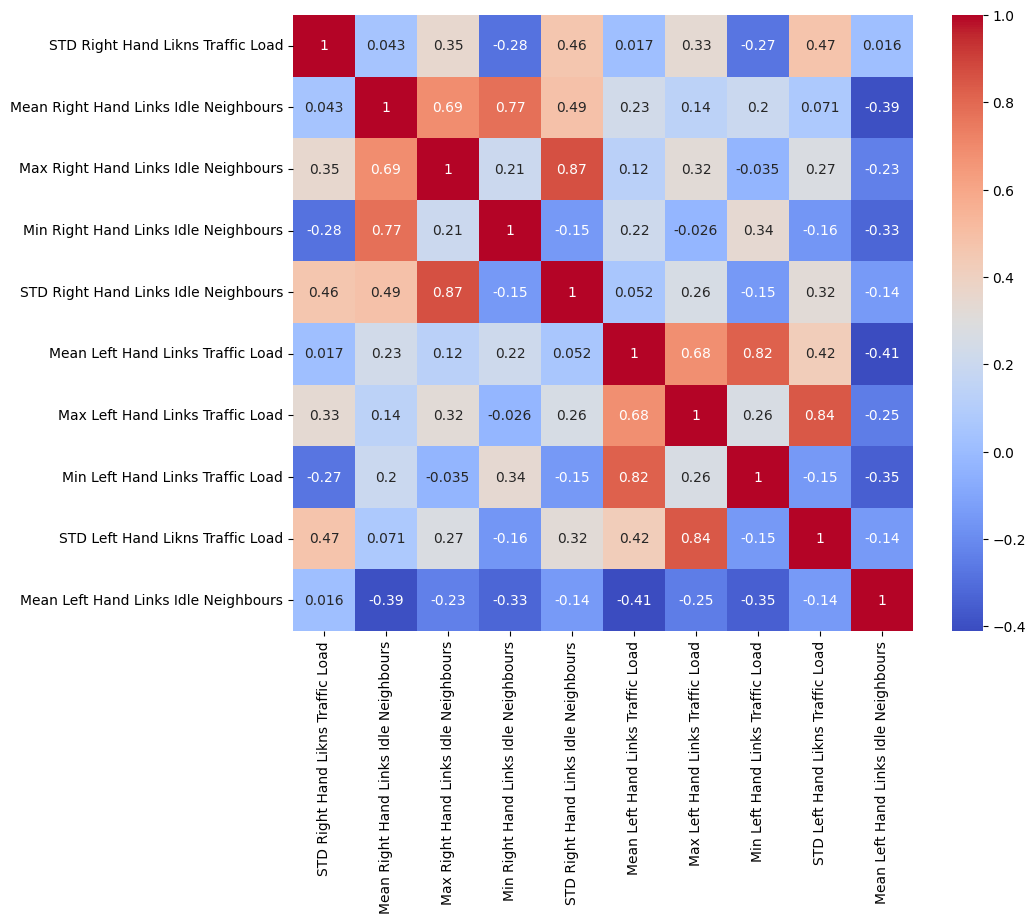

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.iloc[:, 34:44].corr()
# sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
#             cmap=sns.diverging_palette(220, 10, as_cmap=True),
#             square=True, ax=ax)
sns.heatmap(corr, annot=True, cmap='coolwarm')


array([[<Axes: title={'center': 'Lightpath Span Number'}>,
        <Axes: title={'center': 'Mean Right Hand Links Traffic Load'}>],
       [<Axes: title={'center': 'Root Mean Square Link Powers'}>,
        <Axes: title={'center': 'Mean Left Hand Links Idle Neighbours'}>]],
      dtype=object)

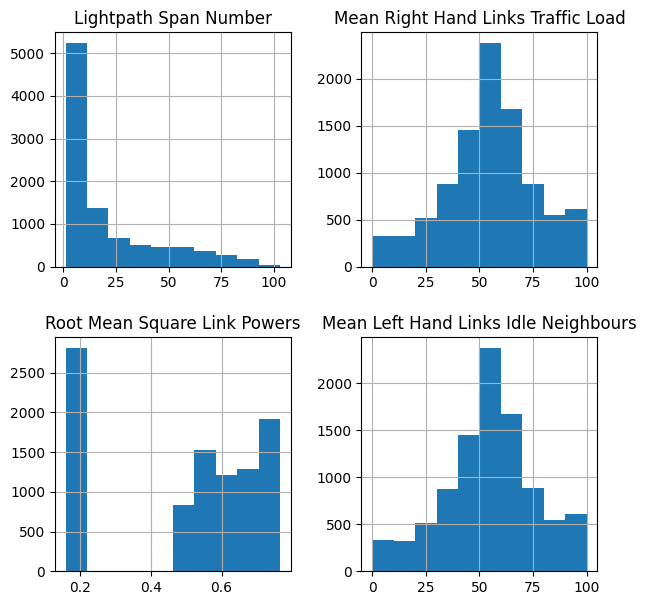

In [ ]:
f1=df[['Modulation Format Level',	'Max Spans Lengths','Lightpath Lengths', 'Link Number']]
f2=df[['Lightpath Span Number','Mean Right Hand Links Traffic Load','Root Mean Square Link Powers','Mean Left Hand Links Idle Neighbours']]

# f1.hist(figsize = (7,7))
f2.hist(figsize = (7,7))

# feature= 'Modulation Format Level'
# target = 'Lightpath GSNR'

# plt.xlabel(feature)
# plt.ylabel(target)

#Scatter Plot:
# plt.scatter(df[feature], df[target])
# plt.title('Scatter Plot of STD Right Hand Links Idle Neighbours and Max Right Hand Links Idle Neighbours')

# # Pairwise Scatter Plot:
# sns.pairplot(df[['Modulation Format Level',	'Max Spans Lengths' ,target]])

# Regression Line Plot:
# sns.regplot(data=df, x=feature, y=target)
# plt.title('Regression Line Plot of Modulation Format Level vs Lightpath GSNR')

# #Histograms and Density Plots:
# plt.hist(df[feature], bins=20)
# plt.title('Histogram of Feature1')

# Correlation Heatmap:
# correlation_matrix = df.corr()
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Heatmap')


In [ ]:
correlation_matrix = X.corrwith(y)

# Sort the features based on their absolute correlation values
sorted_features = correlation_matrix.abs().sort_values(ascending=False)

# Print the top correlated features and their correlation values
print(sorted_features.head(10))

Modulation Format Level     0.963502
Max Links Lengths           0.916959
Max Span Number per Link    0.899671
Lightpath Lengths           0.835398
Max Spans Lengths           0.833392
Lightpath Span Number       0.831201
Min Link Powers             0.816710
Link Number                 0.796725
STD Links Lengths           0.738621
STD Span Number per Link    0.731092
dtype: float64


# **Regression Models**

##**XGB**

###**XGB Regressor**

**XGB Regressor**

In [ ]:
xgb = XGBRegressor()

start_time = time.time()
xgb.fit(X_train, y_train,early_stopping_rounds=10,eval_set=[(X_test, y_test)])
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(xgb)

y_pred = xgb.predict(X_test)
nb_splits = calculate_xgb_splits(xgb)

saveResults(y_test,y_pred,"XGB Regressor",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

**XGB with tuned parameters to get Farhad's Results**


In [ ]:
xgb = XGBRegressor(learning_rate=0.1, subsample=0.3, n_estimators=500)

start_time = time.time()
xgb.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(xgb)

y_pred = xgb.predict(X_test)
nb_splits = calculate_xgb_splits(xgb)
saveResults(y_test,y_pred,"Farhad Results",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

total_splits: 23652


,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,Farhad Results,0.307,0.224,0.997,47,10.661812,0.61,23.125,0.527,23652


**My results**

In [ ]:
params={'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8,
       'reg_alpha':0.5,'reg_lambda':0.5,'gamma':0.2}
xgb = XGBRegressor(**params)

start_time = time.time()
xgb.fit(X_train, y_train,early_stopping_rounds=10,eval_set=[(X_test, y_test)],verbose=False)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(xgb)

y_pred = xgb.predict(X_test)
nb_splits = calculate_xgb_splits(xgb)

saveResults(y_test,y_pred,"XGB with tuning",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

total_splits: 5359


,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,Farhad Results,0.307,0.224,0.997,47,10.661812,0.610,23.125,0.527,23652
1,XGB with tuning,0.283,0.210,0.998,47,4.511100,0.735,48.804,0.465,5359


**TESTING OVERFITTING**

[0]	validation_0-rmse:14.53834
[1]	validation_0-rmse:13.08703
[2]	validation_0-rmse:11.77757
[3]	validation_0-rmse:10.60249
[4]	validation_0-rmse:9.54567
[5]	validation_0-rmse:8.59171
[6]	validation_0-rmse:7.73581
[7]	validation_0-rmse:6.96256
[8]	validation_0-rmse:6.26866
[9]	validation_0-rmse:5.64270
[10]	validation_0-rmse:5.07957
[11]	validation_0-rmse:4.57282
[12]	validation_0-rmse:4.11700
[13]	validation_0-rmse:3.70821
[14]	validation_0-rmse:3.34007
[15]	validation_0-rmse:3.00884
[16]	validation_0-rmse:2.71035
[17]	validation_0-rmse:2.44293
[18]	validation_0-rmse:2.20285
[19]	validation_0-rmse:1.98682
[20]	validation_0-rmse:1.79307
[21]	validation_0-rmse:1.61903
[22]	validation_0-rmse:1.46296
[23]	validation_0-rmse:1.32422
[24]	validation_0-rmse:1.19988
[25]	validation_0-rmse:1.08823
[26]	validation_0-rmse:0.98820
[27]	validation_0-rmse:0.89876
[28]	validation_0-rmse:0.82029
[29]	validation_0-rmse:0.74980
[30]	validation_0-rmse:0.68760
[31]	validation_0-rmse:0.63247
[32]	validatio

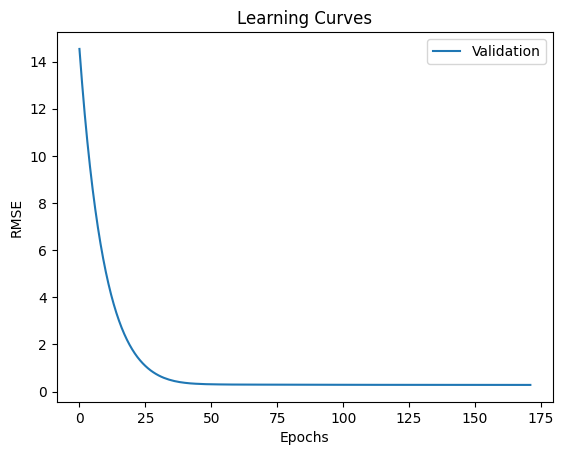

Mean Squared Error with Early Stopping: 0.283185303025542


In [ ]:
params={'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8,
       'reg_alpha':0.5,'reg_lambda':0.5,'gamma':0.2 }
xgb_regressor = XGBRegressor(**params)
xgb_regressor.fit(X_train, y_train,early_stopping_rounds=10,eval_set=[(X_test, y_test)],eval_metric='rmse')

# Evaluate on training data
y_train_pred = xgb_regressor.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
print("Mean Squared Error on Training Data:", np.sqrt(mse_train))

# Evaluate on validation data
y_val_pred = xgb_regressor.predict(X_test)
mse_val = mean_squared_error(y_test, y_val_pred)
print("Mean Squared Error on Validation Data:", np.sqrt(mse_val))

# Plot learning curves (optional)
import matplotlib.pyplot as plt

plt.plot(xgb_regressor.evals_result()['validation_0']['rmse'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Use early stopping to prevent overfitting
xgb_regressor_early = XGBRegressor(**params)
xgb_regressor_early.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

# Evaluate with early stopping
y_val_pred_early = xgb_regressor_early.predict(X_test)
mse_val_early = mean_squared_error(y_test, y_val_pred_early)
print("Mean Squared Error with Early Stopping:", np.sqrt(mse_val_early))

###**GridSearch for hypertuning with CV=5**

In [ ]:
xgb = XGBRegressor()
cv = KFold(n_splits=5, random_state=42, shuffle=True)

#LPLevel Dataset Params
params = {
              'objective':['reg:squarederror'],
              'learning_rate': [0.01,0.1], #0.1
              'max_depth': [3,6,8,12],#6
              'min_child_weight': [1,3],#3
              'subsample': [0.3,0.8], #0.8
              'n_estimators': [100,200,300,500], #500
              'reg_alpha': [0, 0.1, 0.5],#0.5
              'reg_lambda': [0, 0.1, 0.5],#0.5
              'gamma': [0, 0.1, 0.2],#0.2
           }

grid_search = GridSearchCV(xgb, params, cv=cv,scoring = 'r2')

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(grid_search)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

best_reg = grid_search.best_estimator_

y_pred = best_reg.predict(X_test)
saveResults(y_test,y_pred,"XGB with GridSearch CV=5 + Tuning",X.shape[1],training_time,inference_time_per_data_point)
get_results()

In [ ]:
xgb = XGBRegressor()
cv = KFold(n_splits=5, random_state=42, shuffle=True)

#LPLevel Dataset Params
params = {
              'objective':['reg:squarederror'],
              'learning_rate': [0.1], #0.1
              'max_depth': [6],#6
              'min_child_weight': [3],#3
              'subsample': [0.8], #0.8
              'n_estimators': [500], #500
              'reg_alpha': [0.5],#0.5
              'reg_lambda': [0.5],#0.5
              'gamma': [0.2],#0.2
           }

grid_search = GridSearchCV(xgb, params, cv=cv,scoring = 'r2')
grid_search.fit(X_train, y_train,early_stopping_rounds=10,eval_set=[(X_test, y_test)])

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
best_params = grid_search.best_params_
best_reg = grid_search.best_estimator_

best_xgb = XGBRegressor(**best_params)

start_time = time.time()
best_xgb.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(best_xgb)
y_pred = best_xgb.predict(X_test)
saveResults(y_test,y_pred,"XGB with GridSearch CV=5 + Tuning",X.shape[1],training_time,inference_time_per_data_point,'')
get_results()

###**XGB with CV=5 + hyperparameter tuning**

In [ ]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
params={'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8,
       'reg_alpha':0.5,'reg_lambda':0.5,'gamma':0.2 }
xgb_cv = XGBRegressor(**params)

start_time = time.time()
scores = cross_validate(xgb_cv, X_train, y_train, cv=cv,scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(xgb_cv,flag='no_fit')

rmse = sqrt(mean(absolute(scores['test_neg_mean_squared_error'])))
mae= mean(absolute(scores['test_neg_mean_absolute_error']))
r2= mean(absolute(scores['test_r2']))

addResults(rmse,mae,r2,"XGB with CV=5 + tuning ",X.shape[1],training_time,inference_time_per_data_point)
get_results()

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms)
0,XGB Regressor,0.307000,0.227000,0.997000,47,2.468883514404297,2.472000,62.065000,0.45800
1,XGB Regressor,0.306000,0.226000,0.998000,47,6.106178045272827,0.634000,42.605000,0.45300
2,Farhad Results,0.307000,0.224000,0.997000,47,17.7103214263916,0.842000,41.878000,0.53600
3,Farhad Results,0.301000,0.224000,0.998000,47,3.2370896339416504,0.691000,31.004000,0.47500
4,Farhad Results,0.301000,0.224000,0.998000,47,3.7527480125427246,0.864000,41.525000,0.47100
5,XGB with tuning,0.283000,0.210000,0.998000,47,20.95737910270691,2.000000,63.334000,0.47700
6,Farhad Results,0.307000,0.224000,0.997000,47,10.333722829818726,0.768000,37.019000,0.53700
7,XGB with tuning,0.283000,0.210000,0.998000,47,7.390648603439331,0.575000,28.702000,0.47300
8,XGB Regressor,0.306000,0.226000,0.998000,47,4.922172546386719,0.682000,35.995000,0.45200
9,XGB with tuning,0.283000,0.210000,0.998000,47,5.0652313232421875,0.769000,52.815000,0.47200


In [ ]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

params ={'learning_rate': 0.03, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'reg:squarederror',
         'subsample': 0.8, 'reg_alpha': 0.5,'reg_lambda': 0.5,'gamma': 0.2,}


xgb_cv = xgb.XGBRegressor(**params, dtrain=data_dmatrix,
                    num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

start_time = time.time()
xgb_cv.fit(X_train, y_train,eval_set=[(X_test, y_test)])
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(xgb_cv)

y_pred = xgb_cv.predict(X_test)
saveResults(y_test,y_pred,"XGB after tuning",X.shape[1],training_time,inference_time_per_data_point)
get_results()

###**XGB** tuning the params not using GridSearch

In [ ]:
import xgboost as xgb

grid = pd.DataFrame({'eta':[0.01,0.05,0.1],
                    'subsample':([0.3,0.5,0.8]),'max_depth':[3,6,8], 'min_child_weight': [1,2,3],
                     'n_estimators': [100,200,300], 'reg_alpha': [0, 0.1, 0.5],
                     'reg_lambda': [0, 0.1, 0.5],  'gamma': [0, 0.1, 0.2],
})

def fit(x):
    params = {'objective':'reg:squarederror',
              'eval_metric':'mae',
              'eta':x[0],
              'subsample':x[1],
               'max_depth':int(x[2]),
              'min_child_weight':x[3],
               'n_estimators':x[4],
              'reg_alpha':x[5],
               'reg_lambda':x[6],
              'gamma':x[7]
                }
    xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params,
    nfold=5,
    num_boost_round=100, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=42)

    return xgb_cv[-1:].values[0]

grid[['train-rmse-mean','train-rmse-std',
'test-rmse-mean','test-rmse-std']] = grid.apply(fit,axis=1,result_type='expand')
grid


##**GB**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()

start_time = time.time()
gb.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(gb)

y_pred = gb.predict(X_test)
nb_splits = calculate_splits(gb)
saveResults(y_test,y_pred,"GB Regressor",X.shape[1],training_time,inference_time_per_data_point,nb_splits)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(learning_rate=0.1, subsample=0.8, max_depth=3,n_estimators=500)

start_time = time.time()
gb.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(gb)

y_pred = gb.predict(X_test)
nb_splits = calculate_splits(gb)

saveResults(y_test,y_pred,"GB Regressor with tuning",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

Total number of splits: 3476


,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,Farhad Results,0.307,0.224,0.997,47,10.661812,0.610,23.125,0.527,23652
1,XGB with tuning,0.283,0.210,0.998,47,4.511100,0.735,48.804,0.465,5359
2,GB Regressor with tuning,0.281,0.209,0.998,47,24.806895,0.307,4.025,0.192,3476


In [ ]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
param_grid = {
    'learning_rate': [0.01, 0.1], #0.1
    'n_estimators': [100,300,500], #500
    'max_depth': [3,6,8], #3
    'subsample' : [0.3,0.6,0.8] #0.8
}
gb = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv)

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(grid_search)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
best_reg = grid_search.best_estimator_
y_pred = best_reg.predict(X_test)
# nb_splits = calculate_splits(grid_search)

saveResults(y_test,y_pred,"GB Regressor with GS",X.shape[1],training_time,inference_time_per_data_point,'nb_splits')
get_results()

##**HGB**

In [ ]:
hgb = HistGradientBoostingRegressor(early_stopping=10)
start_time = time.time()
hgb.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(hgb)

y_pred = hgb.predict(X_test)
nb_splits = calculate_splits(hgb)
saveResults(y_test,y_pred,"HGB Regressor",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

In [ ]:
params = {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 500}

hgb = HistGradientBoostingRegressor(**params,loss="squared_error", verbose=2, early_stopping=True)

start_time = time.time()
hgb.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(hgb)

y_pred = hgb.predict(X_test)

nb_splits = calculate_hgb_splits(hgb)

saveResults(y_test,y_pred,"HGB with tuning",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

Binning 0.003 GB of training data: 0.055 s
Binning 0.000 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
[1/500] 1 tree, 8 leaves, max depth = 3, train loss: 16.16031, val loss: 15.52440, in 0.005s
[2/500] 1 tree, 8 leaves, max depth = 3, train loss: 13.23391, val loss: 12.70097, in 0.006s
[3/500] 1 tree, 8 leaves, max depth = 3, train loss: 10.84104, val loss: 10.34994, in 0.011s
[4/500] 1 tree, 8 leaves, max depth = 3, train loss: 8.88583, val loss: 8.47543, in 0.009s
[5/500] 1 tree, 8 leaves, max depth = 3, train loss: 7.29217, val loss: 6.93922, in 0.005s
[6/500] 1 tree, 8 leaves, max depth = 3, train loss: 5.98965, val loss: 5.70540, in 0.010s
[7/500] 1 tree, 8 leaves, max depth = 3, train loss: 4.92956, val loss: 4.69603, in 0.005s
[8/500] 1 tree, 8 leaves, max depth = 3, train loss: 4.06000, val loss: 3.87988, in 0.008s
[9/500] 1 tree, 8 leaves, max depth = 3, train loss: 3.34925, val loss: 3.19643, in 0.007s
[10/500] 1 tree, 8 leaves, max depth = 3, train loss: 

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,Farhad Results,0.307,0.224,0.997,47,10.661812,0.610,23.125,0.527,23652
1,XGB with tuning,0.283,0.210,0.998,47,4.511100,0.735,48.804,0.465,5359
2,GB Regressor with tuning,0.281,0.209,0.998,47,24.806895,0.307,4.025,0.192,3476
3,HGB with tuning,0.284,0.209,0.998,47,3.152085,6.023,1413.458,4.689,1320


##**LGB**

In [62]:
from lightgbm import LGBMRegressor

# Train the model
lgb = LGBMRegressor(early_stopping_rounds=100)
start_time = time.time()
lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(lgb)

y_pred = lgb.predict(X_test, num_iteration=lgb.best_iteration_)
nb_splits = calculate_lgb_splits(lgb)

saveResults(y_test,y_pred,"LGB Regressor",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6843
[LightGBM] [Info] Number of data points in the train set: 7675, number of used features: 47
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 15.589584
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0868324
Total number of s

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,LGB Regressor,0.295,0.218,0.998,47,0.765635,0.682,7.679,0.471,3000


In [63]:
from lightgbm import LGBMRegressor
param ={'lambda_l1': 0.1, 'lambda_l2': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'num_leaves':15,
        'min_child_samples': 10, 'min_gain_to_split': 0.01, 'n_estimators': 500,"verbosity" : -1}

# 2^max_depth > num_leaves

lgb =LGBMRegressor(**param,early_stopping_rounds=100)
start_time = time.time()
lgb.fit(X_train, y_train , eval_set=[(X_test, y_test)])
end_time = time.time()
training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(lgb)

y_pred = lgb.predict(X_test)
nb_splits = calculate_lgb_splits(lgb)

saveResults(y_test,y_pred,"LGB Regressor with tuning",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

Total number of splits: 6899


,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,LGB Regressor,0.295,0.218,0.998,47,0.765635,0.682,7.679,0.471,3000
1,LGB Regressor with tuning,0.277,0.203,0.998,47,2.137137,0.608,3.872,0.531,6899


In [ ]:
from lightgbm import LGBMRegressor
cv = KFold(n_splits=5, random_state=42, shuffle=True)
param_grid = {
    'learning_rate': [0.01, 0.1], #0.1
    'n_estimators': [300,500], #500
    'max_depth': [3,6], #3
    'min_child_samples': [10,15],#10
    'lambda_l1':[0,0.1,0.2], 'lambda_l2':[0,0.1,0.2],'min_gain_to_split':[0.1,0.2],'early_stopping_rounds':[10]
}
lgb = LGBMRegressor()
grid_search = GridSearchCV(estimator=lgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv)

start_time = time.time()
grid_search.fit(X_train, y_train,eval_set=[(X_test, y_test)])
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(grid_search)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
best_reg = grid_search.best_estimator_
y_pred = best_reg.predict(X_test)
# nb_splits = calculate_lgb_splits(lgb)

saveResults(y_test,y_pred,"LGB Regressor with GS",X.shape[1],training_time,inference_time_per_data_point,'')
get_results()

Best parameters: {'early_stopping_rounds': 10, 'lambda_l1': 0.1, 'lambda_l2': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 15, 'min_gain_to_split': 0.1, 'n_estimators': 500}
Best score: -0.0913178500882875


##**CatBoost**

In [ ]:
from catboost import CatBoostRegressor

cbr = CatBoostRegressor()
start_time = time.time()
cbr.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(cbr)

y_pred = cbr.predict(X_test)
nb_splits = calculate_cb_splits(cbr)

saveResults(y_test,y_pred,"CAT Boost Regressor",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

In [ ]:
from catboost import CatBoostRegressor
parameters= {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 0.5, 'learning_rate': 0.05,'loss_function':'RMSE',}

cbr = CatBoostRegressor(**parameters,early_stopping_rounds=100)
start_time = time.time()
cbr.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(cbr)

y_pred = cbr.predict(X_test)
nb_splits = calculate_cb_splits(cbr)
saveResults(y_test,y_pred,"CAT Boost Regressor",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

In [ ]:
from catboost import CatBoostRegressor
cv = KFold(n_splits=5, random_state=42, shuffle=True)
param_grid = {
    'iterations': [100,300,500,1000], #1000
    'learning_rate': [0.01,0.03,0.1], #0.3
    'depth': [3, 6,8, 10], #6
    'l2_leaf_reg': [0.2,0.5,1], #0.5
}

cbr = CatBoostRegressor()
grid_search = GridSearchCV(estimator=cbr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv)

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(grid_search)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
best_reg = grid_search.best_estimator_
y_pred = best_reg.predict(X_test)
nb_splits = calculate_cb_splits(cbr)

saveResults(y_test,y_pred,"CAT Boost Regressor ",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

##**Other ML Regressor Models**

###**Decision Tree Regressor**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state = 42)
start_time = time.time()
dt.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(dt)

y_pred = dt.predict(X_test)
nb_splits = calculate_dt_splits(dt)

saveResults(y_test,y_pred,"Decision Tree",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

Total number of splits for Decision Tree Regressor: 7654


,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,Farhad Results,0.307,0.224,0.997,47,10.661812,0.610,23.125,0.527,23652
1,XGB with tuning,0.283,0.210,0.998,47,4.511100,0.735,48.804,0.465,5359
2,GB Regressor with tuning,0.281,0.209,0.998,47,24.806895,0.307,4.025,0.192,3476
3,HGB with tuning,0.284,0.209,0.998,47,3.152085,6.023,1413.458,4.689,1320
4,LGB Regressor with tuning,0.277,0.203,0.998,47,1.345801,0.656,3.953,0.519,6899
5,CAT Boost Regressor,0.274,0.201,0.998,47,8.140874,0.610,8.309,0.411,6000
6,Decision Tree,0.468,0.350,0.994,47,0.208251,0.075,0.527,0.054,7654


In [ ]:
from sklearn.tree import DecisionTreeRegressor
k=5
dt = DecisionTreeRegressor(random_state = 42)
cv = KFold(n_splits=k, random_state=42, shuffle=True)

start_time = time.time()
scores = cross_validate(dt, X_train, y_train, cv=cv,scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
end_time = time.time()

training_time = end_time - start_time

rmse = sqrt(mean(absolute(scores['test_neg_mean_squared_error'])))
mae= mean(absolute(scores['test_neg_mean_absolute_error']))
r2= mean(absolute(scores['test_r2']))
nb_splits = calculate_dt_splits(dt)

inference_time_per_data_point = calc_inference_time(dt,flag=training_time)
addResults(rmse,mae,r2,f'Decision Tree with CV={k}',X.shape[1],training_time,inference_time_per_data_point,nb_splits)

###**Random Forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfc = RandomForestRegressor()

start_time = time.time()
rfc.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(rfc)

y_pred = rfc.predict(X_test)
# nb_splits = calculate_splits(rfc)

saveResults(y_test,y_pred,"Random Forest",X.shape[1],training_time,inference_time_per_data_point,'-')
get_results()

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,Farhad Results,0.307,0.224,0.997,47,10.661812,0.610,23.125,0.527,23652
1,XGB with tuning,0.283,0.210,0.998,47,4.511100,0.735,48.804,0.465,5359
2,GB Regressor with tuning,0.281,0.209,0.998,47,24.806895,0.307,4.025,0.192,3476
3,HGB with tuning,0.284,0.209,0.998,47,3.152085,6.023,1413.458,4.689,1320
4,LGB Regressor with tuning,0.277,0.203,0.998,47,1.345801,0.656,3.953,0.519,6899
5,CAT Boost Regressor,0.274,0.201,0.998,47,8.140874,0.610,8.309,0.411,6000
6,Decision Tree,0.468,0.350,0.994,47,0.208251,0.075,0.527,0.054,7654
7,Random Forest,0.314,0.236,0.997,47,13.787344,3.592,11.531,2.692,-


In [ ]:
from sklearn.ensemble import RandomForestRegressor
k=5
rfc = RandomForestRegressor()
cv = KFold(n_splits=k, random_state=42, shuffle=True)

start_time = time.time()
scores = cross_validate(rfc, X_train, y_train, cv=cv,scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
end_time = time.time()

training_time = end_time - start_time
rmse = sqrt(mean(absolute(scores['test_neg_mean_squared_error'])))
mae= mean(absolute(scores['test_neg_mean_absolute_error']))
r2= mean(absolute(scores['test_r2']))
nb_splits = calculate_splits(rfc)

inference_time_per_data_point = calc_inference_time(rfc,flag=training_time)
addResults(rmse,mae,r2,f'Random Forest with CV={k}',X.shape[1],training_time,inference_time_per_data_point,nb_splits)

In [ ]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

###**Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

start_time = time.time()
lr.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(lr)

y_pred = lr.predict(X_test)
saveResults(y_test,y_pred,"Linear Regression",X.shape[1],training_time,inference_time_per_data_point,'-')
get_results()

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,Farhad Results,0.307,0.224,0.997,47,10.661812,0.610,23.125,0.527,23652
1,XGB with tuning,0.283,0.210,0.998,47,4.511100,0.735,48.804,0.465,5359
2,GB Regressor with tuning,0.281,0.209,0.998,47,24.806895,0.307,4.025,0.192,3476
3,HGB with tuning,0.284,0.209,0.998,47,3.152085,6.023,1413.458,4.689,1320
4,LGB Regressor with tuning,0.277,0.203,0.998,47,1.345801,0.656,3.953,0.519,6899
5,CAT Boost Regressor,0.274,0.201,0.998,47,8.140874,0.610,8.309,0.411,6000
6,Decision Tree,0.468,0.350,0.994,47,0.208251,0.075,0.527,0.054,7654
7,Random Forest,0.314,0.236,0.997,47,13.787344,3.592,11.531,2.692,-
8,Linear Regression,0.641,0.478,0.989,47,0.044929,0.064,2.344,0.049,-


<Axes: >

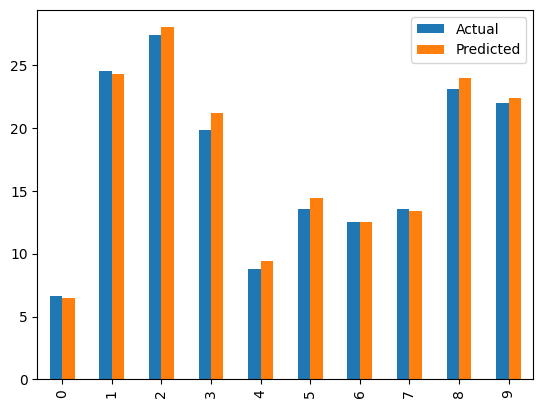

In [ ]:
evaluate = pd.DataFrame({"Actual": y_test.values.flatten(), "Predicted": y_pred.flatten()})
evaluate.head(10)
evaluate.head(10).plot(kind = 'bar')

In [ ]:
selected_features = ['Modulation Format Level', 'Mean Spans Lengths', 'Max Spans Lengths',
       'STD Spans Lengths', 'Min Spans Lengths',  'Ligthpath Total Traffic Load',
       'Mean Links Lengths', 'Max Links Lengths', 'Lightpath Lengths',]
                    #  'Left Hand Lihthpath Traffic Load'
                    #  'Root Mean Square Link Powers', 'Right Hand Lihthpath Traffic Load']

train_selected_features(selected_features,'Linear Regression',model='linear_regression' )

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms)
0,Linear Regression,0.641,0.478,0.989,47,0.015027,0.055,1.052,0.042
1,Feature Selection method: Linear Regression FS,0.832,0.642,0.982,12,0.006560,0.054,4.059,0.041
2,Feature Selection method: Linear Regression FS,0.844,0.645,0.981,10,0.012180,0.052,0.663,0.041
3,Feature Selection method: Linear Regression,0.843,0.645,0.981,9,0.013898,0.065,9.135,0.042


##**DNN Model**

###**Sequential Model**

In [ ]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6144      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 171,009
Trainable params: 171,009
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
start_time = time.time()
NN_model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)
end_time = time.time()

training_time = end_time - start_time
# inference_time_per_data_point = calc_inference_time(NN_model)
inference_time_per_data_point = (83.917, 824.466, 51.541)

Epoch 1/500
230/240 [===========================>..] - ETA: 0s - loss: 2.7867 - mean_absolute_error: 2.7867
Epoch 1: val_loss improved from inf to 1.40042, saving model to Weights-001--1.40042.hdf5
240/240 [==============================] - 8s 6ms/step - loss: 2.7393 - mean_absolute_error: 2.7393 - val_loss: 1.4004 - val_mean_absolute_error: 1.4004
Epoch 2/500
231/240 [===========================>..] - ETA: 0s - loss: 1.2147 - mean_absolute_error: 1.2147
Epoch 2: val_loss improved from 1.40042 to 1.00392, saving model to Weights-002--1.00392.hdf5
240/240 [==============================] - 3s 12ms/step - loss: 1.2153 - mean_absolute_error: 1.2153 - val_loss: 1.0039 - val_mean_absolute_error: 1.0039
Epoch 3/500
239/240 [============================>.] - ETA: 0s - loss: 1.0758 - mean_absolute_error: 1.0758
Epoch 3: val_loss did not improve from 1.00392
240/240 [==============================] - 1s 4ms/step - loss: 1.0752 - mean_absolute_error: 1.0752 - val_loss: 1.0129 - val_mean_absolute

In [ ]:
wights_file = 'Weights-470--0.21122.hdf5' # choose the best checkpoint
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

y_pred = NN_model.predict(X_test)
total_params = NN_model.count_params()

print("Total parameters for Keras Sequential DNN:", total_params)
saveResults(y_test,y_pred,"Keras Sequential DNN",X.shape[1],training_time,inference_time_per_data_point,total_params)
get_results()

60/60 [==============================] - 0s 1ms/step
Total parameters for Keras Sequential DNN: 171009


,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,Farhad Results,0.307,0.224,0.997,47,10.661812,0.610,23.125,0.527,23652
1,XGB with tuning,0.283,0.210,0.998,47,4.511100,0.735,48.804,0.465,5359
2,GB Regressor with tuning,0.281,0.209,0.998,47,24.806895,0.307,4.025,0.192,3476
3,HGB with tuning,0.284,0.209,0.998,47,3.152085,6.023,1413.458,4.689,1320
4,LGB Regressor with tuning,0.277,0.203,0.998,47,1.345801,0.656,3.953,0.519,6899
5,CAT Boost Regressor,0.274,0.201,0.998,47,8.140874,0.610,8.309,0.411,6000
6,Decision Tree,0.468,0.350,0.994,47,0.208251,0.075,0.527,0.054,7654
7,Random Forest,0.314,0.236,0.997,47,13.787344,3.592,11.531,2.692,-
8,Linear Regression,0.641,0.478,0.989,47,0.044929,0.064,2.344,0.049,-
9,Keras Sequential DNN,0.292,0.211,0.998,47,742.848444,83.917,824.466,51.541,171009


###**DNN with Gridsearch CV=5**

In [ ]:
def create_model(optimizer = 'adam'):
    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

    # The Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    return NN_model

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

param_grid_dnn = {
    'epochs': [100],
     'batch_size': [128],
}
dnn_model = KerasRegressor(build_fn=create_model, verbose=0)

grid_search_dnn = GridSearchCV(estimator=dnn_model,
                               param_grid=param_grid_dnn,
                               scoring='neg_mean_squared_error',
                               cv=5,
                               n_jobs=-1)
start_time = time.time()
grid_search_dnn.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
# inference_time_per_data_point = calc_inference_time(grid_search_dnn)

# Best DNN model and best hyperparameters
best_dnn_model = grid_search_dnn.best_estimator_
best_dnn_params = grid_search_dnn.best_params_

print("Best DNN Hyperparameters:", best_dnn_params)

y_pred = best_dnn_model.predict(X_test)

inference_time_per_data_point = (end_time - start_time) / num_data_points
saveResults(y_test,y_pred,"DNN with GridSearch",X.shape[1],training_time,'inference_time_per_data_point')

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms)
0,XGB Regressor,0.307,0.227,0.997,47,2.468883514404297,2.472,62.065,0.458
1,XGB Regressor,0.306,0.226,0.998,47,6.106178045272827,0.634,42.605,0.453
2,Farhad Results,0.307,0.224,0.997,47,17.7103214263916,0.842,41.878,0.536
3,Farhad Results,0.301,0.224,0.998,47,3.2370896339416504,0.691,31.004,0.475
4,Farhad Results,0.301,0.224,0.998,47,3.7527480125427246,0.864,41.525,0.471
5,XGB with tuning,0.283,0.210,0.998,47,20.95737910270691,2.000,63.334,0.477
6,Farhad Results,0.307,0.224,0.997,47,10.333722829818726,0.768,37.019,0.537
7,XGB with tuning,0.283,0.210,0.998,47,7.390648603439331,0.575,28.702,0.473
8,XGB Regressor,0.306,0.226,0.998,47,4.922172546386719,0.682,35.995,0.452
9,XGB with tuning,0.283,0.210,0.998,47,5.0652313232421875,0.769,52.815,0.472


In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

dnn_model = KerasRegressor(build_fn=create_model, verbose=0,epochs=100,batch_size=128)

start_time = time.time()
dnn_model.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
# inference_time_per_data_point = calc_inference_time(dnn_model)
y_pred = dnn_model.predict(X_test)

saveResults(y_test,y_pred,"DNN with GridSearch",X.shape[1],training_time,inference_time_per_data_point)
get_results()

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms)
0,XGB Regressor,0.307,0.227,0.997,47,2.468883514404297,2.472,62.065,0.458
1,XGB Regressor,0.306,0.226,0.998,47,6.106178045272827,0.634,42.605,0.453
2,Farhad Results,0.307,0.224,0.997,47,17.7103214263916,0.842,41.878,0.536
3,Farhad Results,0.301,0.224,0.998,47,3.2370896339416504,0.691,31.004,0.475
4,Farhad Results,0.301,0.224,0.998,47,3.7527480125427246,0.864,41.525,0.471
5,XGB with tuning,0.283,0.210,0.998,47,20.95737910270691,2.000,63.334,0.477
6,Farhad Results,0.307,0.224,0.997,47,10.333722829818726,0.768,37.019,0.537
7,XGB with tuning,0.283,0.210,0.998,47,7.390648603439331,0.575,28.702,0.473
8,XGB Regressor,0.306,0.226,0.998,47,4.922172546386719,0.682,35.995,0.452
9,XGB with tuning,0.283,0.210,0.998,47,5.0652313232421875,0.769,52.815,0.472


###**MLP**

In [ ]:
from sklearn.neural_network import MLPRegressor

dnn_param_grid = {
    'hidden_layer_sizes': [ (100,),(50,),(50,50)],  # Number of neurons in each hidden layer
    'activation': ['relu'],  # Activation function
    'learning_rate_init': [ 0.01,0.03],  # Initial learning rate,
  'learning_rate':  ['adaptive'],
     'batch_size': [16,32,128],
    'early_stopping':[True]
}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
dnn_reg = MLPRegressor(random_state=42)

grid_search_dnn = GridSearchCV(dnn_reg, dnn_param_grid, cv=cv, scoring='neg_mean_squared_error')

start_time = time.time()
grid_search_dnn.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(grid_search_dnn)
best_dnn_model = grid_search_dnn.best_estimator_
best_dnn_params = grid_search_dnn.best_params_

print("Best DNN Hyperparameters:", best_dnn_params)
y_pred_dnn = best_dnn_model.predict(X_test)

total_params = best_dnn_model.n_layers_ - 1  # Excluding the input layer
print("Total layers for MLP Regressor:", total_params)

saveResults(y_test,y_pred_dnn,"MLP with tuning",X.shape[1],training_time,inference_time_per_data_point,total_params)
get_results()

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(random_state=42)

start_time = time.time()
mlp.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(mlp)

y_pred_dnn = mlp.predict(X_test)
total_params=sum(param.size for param in mlp.coefs_) + sum(param.size for param in mlp.intercepts_)

print("Total layers for MLP Regressor:", total_params)
saveResults(y_test,y_pred_dnn,"MLP with tuning",X.shape[1],training_time,inference_time_per_data_point,total_params)
get_results()

Total layers for MLP Regressor: 4901


,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,Farhad Results,0.307,0.224,0.997,47,10.661812,0.610,23.125,0.527,23652
1,XGB with tuning,0.283,0.210,0.998,47,4.511100,0.735,48.804,0.465,5359
2,GB Regressor with tuning,0.281,0.209,0.998,47,24.806895,0.307,4.025,0.192,3476
3,HGB with tuning,0.284,0.209,0.998,47,3.152085,6.023,1413.458,4.689,1320
4,LGB Regressor with tuning,0.277,0.203,0.998,47,1.345801,0.656,3.953,0.519,6899
5,CAT Boost Regressor,0.274,0.201,0.998,47,8.140874,0.610,8.309,0.411,6000
6,Decision Tree,0.468,0.350,0.994,47,0.208251,0.075,0.527,0.054,7654
7,Random Forest,0.314,0.236,0.997,47,13.787344,3.592,11.531,2.692,-
8,Linear Regression,0.641,0.478,0.989,47,0.044929,0.064,2.344,0.049,-
9,Keras Sequential DNN,0.292,0.211,0.998,47,742.848444,83.917,824.466,51.541,171009


4901

## **EVALUATION**

In [ ]:
get_results()

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,Farhad Results,0.307,0.224,0.997,47,10.661812,0.610,23.125,0.527,23652
1,XGB with tuning,0.283,0.210,0.998,47,4.511100,0.735,48.804,0.465,5359
2,GB Regressor with tuning,0.281,0.209,0.998,47,24.806895,0.307,4.025,0.192,3476
3,HGB with tuning,0.284,0.209,0.998,47,3.152085,6.023,1413.458,4.689,1320
4,LGB Regressor with tuning,0.277,0.203,0.998,47,1.345801,0.656,3.953,0.519,6899
5,CAT Boost Regressor,0.274,0.201,0.998,47,8.140874,0.610,8.309,0.411,6000
6,Decision Tree,0.468,0.350,0.994,47,0.208251,0.075,0.527,0.054,7654
7,Random Forest,0.314,0.236,0.997,47,13.787344,3.592,11.531,2.692,-
8,Linear Regression,0.641,0.478,0.989,47,0.044929,0.064,2.344,0.049,-
9,Keras Sequential DNN,0.292,0.211,0.998,47,742.848444,83.917,824.466,51.541,171009


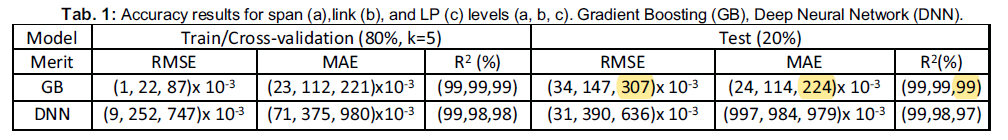

#**SHAP Explanations**

In [ ]:
explainer = shap.TreeExplainer(xgb) #replace model with either lgb or xgb or cbr
shap_values = explainer.shap_values(X_test)
# shap_interaction_values = shap.TreeExplainer(xgb).shap_interaction_values(X_test)

###***Global Explanations show importance of each feature***

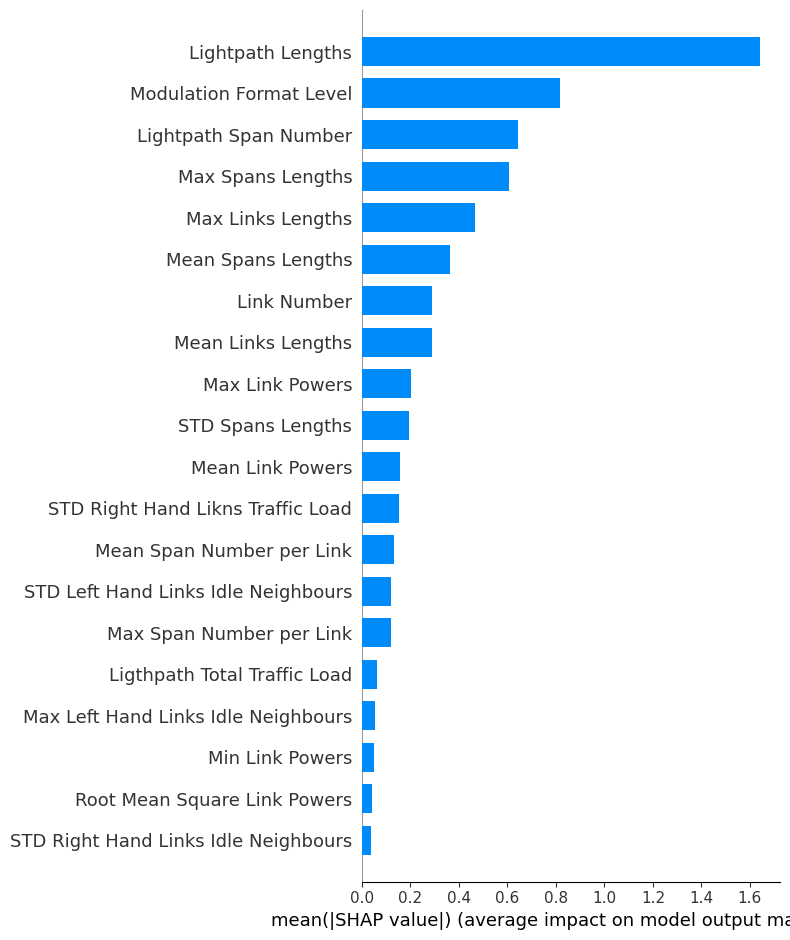

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

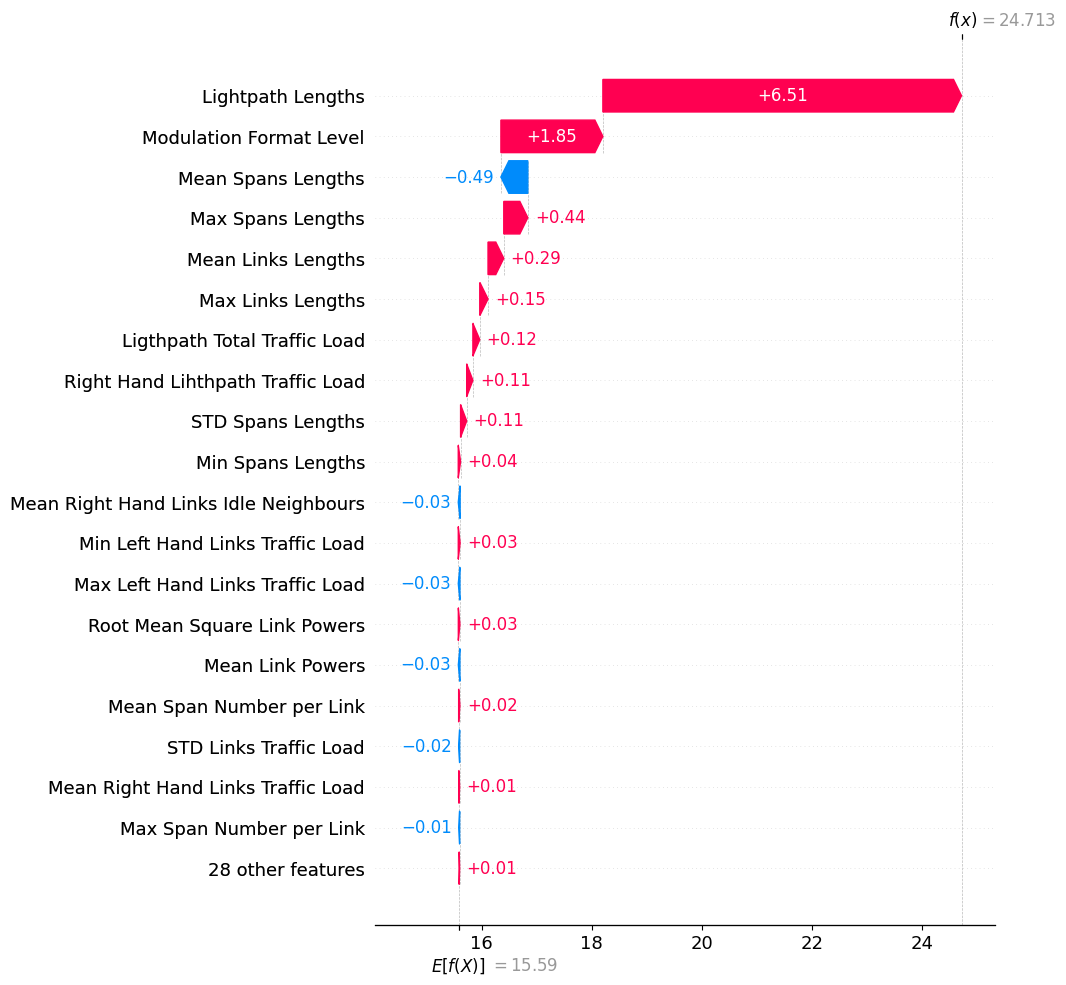

In [ ]:
shap.waterfall_plot(shap.Explanation(values=shap_values[1],feature_names=X_train.columns, base_values=xgb.predict(X_train).mean()), max_display=20)

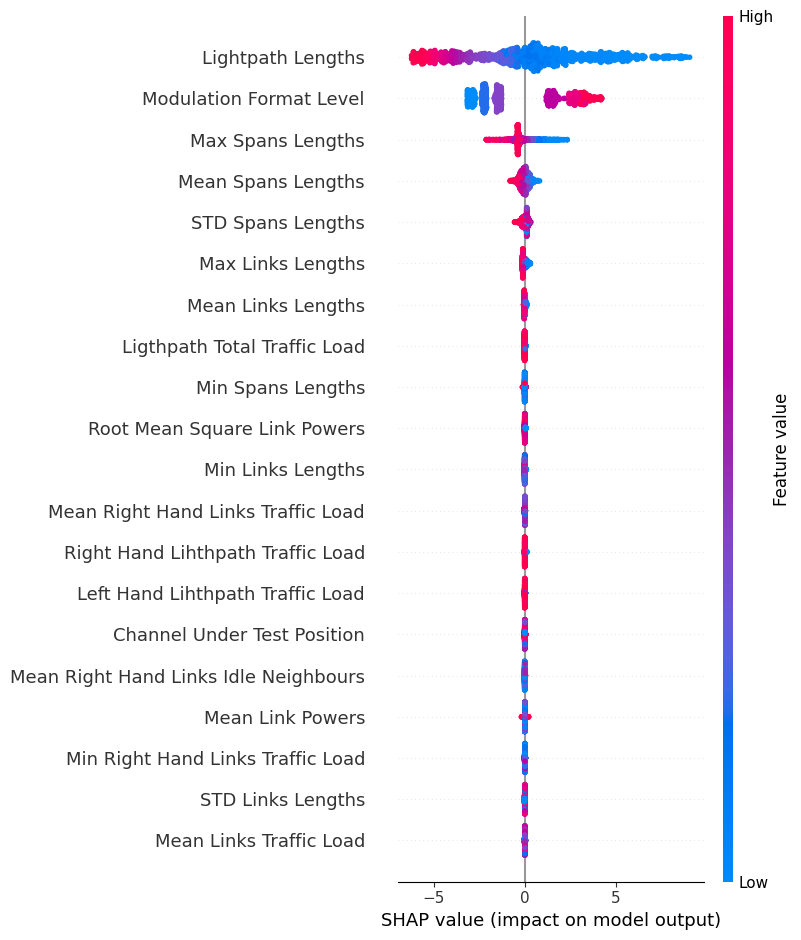

In [ ]:
shap.summary_plot(shap_values, X_test)

# shap.dependence_plot("Lightpath Lengths", shap_values, X_test)
# shap.dependence_plot("Modulation Format Level", shap_values, X_test)
# shap.dependence_plot(("Lightpath Lengths","Modulation Format Level"), shap_interaction_values, X_test)
# shap.dependence_plot(("Max Links Lengths","Max Spans Lengths"), shap_interaction_values, X_test)


In [ ]:
shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:],matplotlib=True,show=False)
# shap.force_plot(explainer.expected_value, shap_values[0:500,:], X_test.iloc[0:500,:])
plt.savefig("shap_force_plot.jpg")

###***Local Shap Individual Predictions***

In [ ]:
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(xgb.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,330,50) # Every 50 rows
S = X_output.iloc[random_picks]
S

,Modulation Format Level,Link Number,Mean Spans Lengths,Max Spans Lengths,Min Spans Lengths,STD Spans Lengths,Ligthpath Total Traffic Load,Mean Links Traffic Load,Max Links Traffic Load,Min Links Traffic Load,...,STD Right Hand Links Idle Neighbours,Mean Left Hand Links Traffic Load,Max Left Hand Links Traffic Load,Min Left Hand Links Traffic Load,STD Left Hand Likns Traffic Load,Mean Left Hand Links Idle Neighbours,Max Left Hand Links Idle Neighbours,Min Left Hand Links Idle Neighbours,STD Left Hand Links Idle Neighbours,predict
7370,6,1,97.000,97,97,0.000,15.254,57.458,98.305,11.864,...,0.00000,16.00000,16,16,0.00000,11.765,11.765,11.765,0.000,24.900000
2189,5,1,104.000,104,104,0.000,47.458,55.847,83.051,11.864,...,0.00000,0.00000,0,0,0.00000,52.941,52.941,52.941,0.000,19.969999
6160,3,2,85.444,111,55,17.120,84.746,61.017,96.610,25.424,...,0.00000,1.50000,3,0,2.12130,47.727,77.273,18.182,41.784,13.100000
2907,5,1,62.600,87,51,15.758,37.288,49.068,100.000,13.559,...,0.00000,0.00000,0,0,0.00000,0.000,0.000,0.000,0.000,22.809999
2018,3,4,75.769,109,50,16.458,100.000,57.881,98.305,16.949,...,1.89300,0.75000,2,0,0.95743,71.429,100.000,42.857,26.082,15.340000
7063,1,12,84.179,117,51,19.856,100.000,58.559,100.000,23.729,...,0.28868,0.83333,7,0,2.03750,63.542,100.000,33.929,20.253,7.810000
346,3,2,88.455,120,64,19.881,49.153,48.220,98.305,20.339,...,4.94970,2.50000,4,1,2.12130,27.419,29.032,25.806,2.281,14.140000


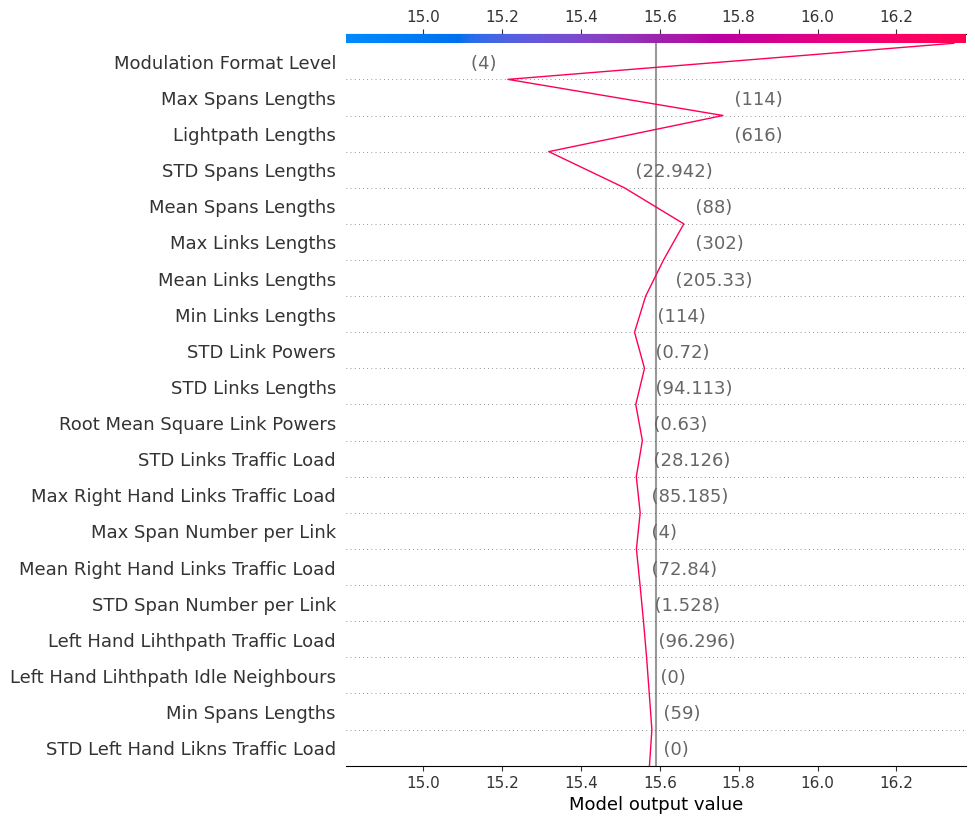

In [ ]:
shap.initjs()
i=209
def shap_plot(j):
    explainerModel = shap.TreeExplainer(xgb)
    shap_values_Model = explainerModel.shap_values(X_test)
    # p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X_test.iloc[[j]],matplotlib=True,show=False)
    p= shap.decision_plot(explainerModel.expected_value, shap_values_Model[j], X_test.iloc[[j]])
    return(p)

# avgValues = X_train.mean()
# print(avgValues)
shap_plot(i)
# plt.savefig(f'shap_force_plot_{i}.jpg')

#**Feature selection**

In [ ]:
feature_selection_type='xgb' #can only take lgb or xgb or cbr
feature_selection_model=xgb

##**Method 1: Powershap**

In [ ]:
! pip install powershap
from powershap import PowerShap

# please, use agnostic = True to use with any model...
# agnostic = False will only work with tree-based models

In [ ]:
model_ps = feature_selection_model
if feature_selection_type == 'cbr'
  selector_cbr = CatBoostRegressor()
  selector = PowerShap(
    model = selector_cbr,
    automatic=True, limit_automatic=100)
else:
  selector = PowerShap(
      model = model_ps,
      automatic=True, limit_automatic=100)

selector.fit(X_train, y_train)

selected_features_ps = selector.transform(X_train).columns
print(selector._processed_shaps_df)
train_selected_features_with_hypertuning(selected_features_ps,f'PowerShap for {feature_selection_type}',model=feature_selection_type)

###**Saved Powershap Models**

In [ ]:
params_xgb = {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8,'reg_alpha':0.1,'reg_lambda':0.1,'gamma':0.2 }
selected_features_xgb=['Modulation Format Level', 'Mean Spans Lengths', 'Max Spans Lengths', 'STD Spans Lengths', 'Ligthpath Total Traffic Load', 'Mean Links Lengths', 'Max Links Lengths', 'Lightpath Lengths', 'Root Mean Square Link Powers']
train_prepared_model (selected_features_xgb,params_xgb,'xgb',f'PowerShap for XGB')

In [ ]:
params_lgb = {'learning_rate': 0.05, 'max_depth': 6, 'min_child_samples': 15, 'n_estimators': 500,'num_leaves':40}
selected_features_lgb=['Modulation Format Level', 'Mean Spans Lengths', 'Max Spans Lengths', 'Min Spans Lengths', 'STD Spans Lengths', 'Mean Links Lengths',
                       'Max Links Lengths', 'Min Links Lengths', 'Lightpath Lengths', 'Root Mean Square Link Powers', 'Mean Right Hand Links Traffic Load']
train_prepared_model (selected_features_lgb,params_lgb,'lgb',f'PowerShap for LGB')

In [ ]:
params_cb = {'depth': 6, 'iterations': 500, 'l2_leaf_reg': 0.5, 'learning_rate': 0.1}
selected_features_cb=['Modulation Format Level', 'Link Number', 'Mean Spans Lengths', 'Max Spans Lengths','Min Spans Lengths', 'STD Spans Lengths',
                      'Ligthpath Total Traffic Load', 'Mean Links Lengths', 'Max Links Lengths', 'Min Links Lengths', 'STD Links Lengths', 'Lightpath Lengths',
                      'Mean Span Number per Link', 'Max Span Number per Link', 'Lightpath Span Number', 'Mean Link Powers', 'Root Mean Square Link Powers',
                      'Min Link Powers', 'STD Link Powers']
train_prepared_model (selected_features_cb,params_cb,'cbr',f'PowerShap for CatBoost')

##**Method 2: Shaphypetune**

In [ ]:
! pip install shap-hypetune
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta

In [ ]:
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta
param_grid = {
              'objective':['reg:squarederror'],
              'learning_rate': [0.01,0.1], #0.1
              'max_depth': [3,6],#6
              'min_child_weight': [1,3],#3
              'subsample': [0.3,0.8], #0.8
              'n_estimators': [300,500], #500
              'reg_alpha': [0.1, 0.5],#0.5
              'reg_lambda': [ 0.1, 0.5],#0.5
              'gamma': [ 0.1, 0.2],#0.2
           }
xgb_model = XGBRegressor()
X_train, X_valid, y_train, y_valid = train_test_split(
X_train, y_train, test_size=0.2, shuffle=True, random_state=33)
model = BoostSearch(xgb_model, param_grid=param_grid, greater_is_better=True)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='mae', early_stopping_rounds=3, verbose=0)
y_pred =  model.estimator_.predict(X_test)
print( model.best_params_)
saveResults(y_test,y_pred,"XGB with BoostSearch",'training_time','inference_time_per_data_point')
get_results()

In [ ]:
X_regr_train, X_regr_valid, y_regr_train, y_regr_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False)

###**Boruta**

In [ ]:
model_boruta = BoostBoruta(feature_selection_model, max_iter=200, perc=100,importance_type='shap_importances', train_importance=False)
model_boruta.fit(X_regr_train, y_regr_train, eval_set=[(X_regr_valid, y_regr_valid)],eval_metric='mae', early_stopping_rounds=6, verbose=0)

selected_features_br = (model_boruta.transform(X_regr_valid).columns) #to see which features

# train_selected_features(selected_features_br,'Boruta',model=feature_selection_type)
train_selected_features_with_hypertuning(selected_features_br,f'Boruta + Tuning',model=feature_selection_type)
get_results()

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8}


####**Saved Models**

**XGB**

In [ ]:
params_xgb ={'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8,'reg_alpha':0.1,'reg_lambda':0.1,'gamma':0.2}
selected_features_xgb=['Modulation Format Level', 'Mean Spans Lengths', 'Max Spans Lengths', 'Min Spans Lengths', 'STD Spans Lengths', 'Ligthpath Total Traffic Load', 'Mean Links Lengths', 'Max Links Lengths',
                       'Min Links Lengths', 'Lightpath Lengths', 'Root Mean Square Link Powers','Right Hand Lihthpath Traffic Load', 'Mean Right Hand Links Traffic Load']
train_prepared_model (selected_features_xgb,params_xgb,'xgb',f'Boruta for XGB')

total_splits: 3279


,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,PowerShap for XGB,0.279,0.205,0.998,9,1.859238,0.554,9.433,0.490,3169
1,PowerShap for CatBoost,0.278,0.202,0.998,19,7.066689,0.794,39.769,0.385,3000
2,PowerShap for LGB,0.277,0.203,0.998,11,1.233359,0.731,11.719,0.533,16097
3,Boruta for XGB,0.280,0.206,0.998,13,4.004735,0.562,10.639,0.491,3279
4,RFE for XGB,0.278,0.205,0.998,12,4.361500,0.817,40.776,0.499,7349
5,RFA for XGB,0.285,0.209,0.998,27,7.097307,0.730,36.031,0.494,7257
6,Boruta for XGB,0.280,0.206,0.998,13,2.775791,0.562,9.206,0.492,3279


**LGB**

In [76]:
params_lgb = {'learning_rate': 0.05, 'max_depth': 6, 'min_child_samples': 15, 'n_estimators': 500,'num_leaves':32}
selected_features_lgb=['Modulation Format Level', 'Mean Spans Lengths', 'Max Spans Lengths', 'Min Spans Lengths', 'STD Spans Lengths', 'Ligthpath Total Traffic Load', 'Mean Links Lengths', 'Max Links Lengths',
                       'Min Links Lengths', 'Lightpath Lengths', 'Root Mean Square Link Powers','Right Hand Lihthpath Traffic Load', 'Mean Right Hand Links Traffic Load']
train_prepared_model (selected_features_lgb,params_lgb,'lgb',f'Boruta for LGB')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2244
[LightGBM] [Info] Number of data points in the train set: 7675, number of used features: 13
[LightGBM] [Info] Start training from score 15.589584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,LGB Regressor,0.295,0.218,0.998,47,0.765635,0.682,7.679,0.471,3000
1,LGB Regressor with tuning,0.277,0.203,0.998,47,2.137137,0.608,3.872,0.531,6899
2,PowerShap for LGB,0.277,0.203,0.998,11,0.734508,0.598,5.730,0.525,16097
3,Boruta for LGB,0.280,0.205,0.998,13,0.668271,0.664,4.827,0.523,14298
4,RFE for LGB,0.279,0.204,0.998,9,0.633306,0.658,4.413,0.519,15509
5,RFA for LGB,0.279,0.206,0.998,30,1.213514,0.668,6.289,0.523,14416
6,Boruta for LGB,0.280,0.205,0.998,13,0.699822,0.586,1.782,0.520,14298
7,RFE for LGB,0.279,0.204,0.998,9,1.003595,0.600,3.956,0.517,15509
8,RFA for LGB,0.279,0.206,0.998,30,1.134120,0.680,5.969,0.530,14416
9,RFA for LGB,0.279,0.206,0.998,30,1.149224,0.668,4.188,0.529,14416


###**RFE**

In [ ]:
model_rfe = BoostRFE(feature_selection_model, min_features_to_select=1, step=1,importance_type='shap_importances', train_importance=False)
model_rfe.fit(X_regr_train, y_regr_train, eval_set=[(X_regr_valid, y_regr_valid)],eval_metric='rmse', early_stopping_rounds=6, verbose=0)

selected_features_rfe = (model_rfe.transform(X_regr_valid).columns) #to see which features
# train_selected_features(selected_features_rfe,'RFE',model=feature_selection_type)
train_selected_features_with_hypertuning(selected_features_rfe,f'RFE + Tuning',model=feature_selection_type)

####**Saved Models**

**XGB**

In [ ]:
params_xgb = {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'objective': 'reg:squarederror', 'subsample': 0.8,'reg_alpha':0.1,'reg_lambda':0.1,'gamma':0.2}
selected_features_xgb=[
    "Modulation Format Level",
    "Mean Spans Lengths",
    "Max Spans Lengths",
    "Min Spans Lengths",
    "STD Spans Lengths",
    "Ligthpath Total Traffic Load",
    "Mean Links Lengths",
    "Max Links Lengths",
    "Min Links Lengths",
    "Lightpath Lengths",
    "Root Mean Square Link Powers",
    "Mean Right Hand Links Traffic Load"
]
train_prepared_model (selected_features_xgb,params_xgb,'xgb',f'RFE for XGB')

total_splits: 7349


,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,PowerShap for XGB,0.279,0.205,0.998,9,1.859238,0.554,9.433,0.490,3169
1,PowerShap for CatBoost,0.278,0.202,0.998,19,7.066689,0.794,39.769,0.385,3000
2,PowerShap for LGB,0.277,0.203,0.998,11,1.233359,0.731,11.719,0.533,16097
3,Boruta for XGB,0.280,0.206,0.998,13,4.004735,0.562,10.639,0.491,3279
4,RFE for XGB,0.278,0.205,0.998,12,4.361500,0.817,40.776,0.499,7349
5,RFA for XGB,0.285,0.209,0.998,27,7.097307,0.730,36.031,0.494,7257
6,Boruta for XGB,0.280,0.206,0.998,13,2.775791,0.562,9.206,0.492,3279
7,RFE for XGB,0.278,0.205,0.998,12,4.405652,0.556,10.319,0.491,7349


**LGB**

In [74]:
params_lgb = {'learning_rate': 0.05, 'max_depth': 6, 'min_child_samples': 15, 'n_estimators': 500,'num_leaves':40}
selected_features_lgb=['Modulation Format Level', 'Mean Spans Lengths', 'Max Spans Lengths','STD Spans Lengths','Ligthpath Total Traffic Load',
                       'Mean Links Lengths', 'Max Links Lengths','Lightpath Lengths', 'Root Mean Square Link Powers']
train_prepared_model (selected_features_lgb,params_lgb,'lgb',f'RFE for LGB')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1430
[LightGBM] [Info] Number of data points in the train set: 7675, number of used features: 9
[LightGBM] [Info] Start training from score 15.589584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,LGB Regressor,0.295,0.218,0.998,47,0.765635,0.682,7.679,0.471,3000
1,LGB Regressor with tuning,0.277,0.203,0.998,47,2.137137,0.608,3.872,0.531,6899
2,PowerShap for LGB,0.277,0.203,0.998,11,0.734508,0.598,5.730,0.525,16097
3,Boruta for LGB,0.280,0.205,0.998,13,0.668271,0.664,4.827,0.523,14298
4,RFE for LGB,0.279,0.204,0.998,9,0.633306,0.658,4.413,0.519,15509
5,RFA for LGB,0.279,0.206,0.998,30,1.213514,0.668,6.289,0.523,14416
6,Boruta for LGB,0.280,0.205,0.998,13,0.699822,0.586,1.782,0.520,14298
7,RFE for LGB,0.279,0.204,0.998,9,1.003595,0.600,3.956,0.517,15509
8,RFA for LGB,0.279,0.206,0.998,30,1.134120,0.680,5.969,0.530,14416
9,RFA for LGB,0.279,0.206,0.998,30,1.149224,0.668,4.188,0.529,14416


###**RFA**

In [ ]:
from hyperopt import Trials

model_rfa = BoostRFA(feature_selection_model, min_features_to_select=1, step=1,importance_type='shap_importances', train_importance=False)
model_rfa.fit(X_regr_train, y_regr_train, trials=Trials(),eval_set=[(X_regr_valid, y_regr_valid)],eval_metric='mae')
#,early_stopping_rounds=6, verbose=0)

selected_features_rfa = (model_rfa.transform(X_regr_valid).columns) #to see which features
# train_selected_features(selected_features_rfa,'RFA',model=feature_selection_type)
train_selected_features_with_hypertuning(selected_features_rfa,f'RFA + Tuning',model=feature_selection_type)

####**Saved Models**

**XGB**

In [ ]:
params_xgb ={'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'objective': 'reg:squarederror', 'subsample': 0.8,'reg_alpha':0.1,'reg_lambda':0.1,'gamma':0.2}
selected_features_xgb=[
    "Modulation Format Level","Link Number","Mean Spans Lengths","Max Spans Lengths", "Min Spans Lengths","STD Spans Lengths","Ligthpath Total Traffic Load",
    "Mean Links Lengths","Max Links Lengths","Min Links Lengths","STD Links Lengths","Lightpath Lengths","Mean Span Number per Link","Max Span Number per Link",
    "STD Span Number per Link","Lightpath Span Number","Mean Link Powers", "Root Mean Square Link Powers", "Max Link Powers","Min Link Powers","STD Link Powers",
    "Right Hand Lihthpath Traffic Load","Left Hand Lihthpath Traffic Load",
"STD Right Hand Likns Traffic Load","STD Right Hand Links Idle Neighbours","STD Left Hand Likns Traffic Load","STD Left Hand Links Idle Neighbours"]
train_prepared_model (selected_features_xgb,params_xgb,'xgb',f'RFA for XGB')

total_splits: 7257


,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,PowerShap for XGB,0.279,0.205,0.998,9,1.859238,0.554,9.433,0.490,3169
1,PowerShap for CatBoost,0.278,0.202,0.998,19,7.066689,0.794,39.769,0.385,3000
2,PowerShap for LGB,0.277,0.203,0.998,11,1.233359,0.731,11.719,0.533,16097
3,Boruta for XGB,0.280,0.206,0.998,13,4.004735,0.562,10.639,0.491,3279
4,RFE for XGB,0.278,0.205,0.998,12,4.361500,0.817,40.776,0.499,7349
5,RFA for XGB,0.285,0.209,0.998,27,7.097307,0.730,36.031,0.494,7257
6,Boruta for XGB,0.280,0.206,0.998,13,2.775791,0.562,9.206,0.492,3279
7,RFE for XGB,0.278,0.205,0.998,12,4.405652,0.556,10.319,0.491,7349
8,RFA for XGB,0.285,0.209,0.998,27,6.251560,0.574,5.741,0.499,7257


**LGB**

In [73]:
params_lgb = {'learning_rate': 0.05, 'max_depth': 6, 'min_child_samples': 15, 'n_estimators': 500,'num_leaves':32}
selected_features_lgb=["Modulation Format Level","Link Number","Mean Spans Lengths","Max Spans Lengths", "Min Spans Lengths","STD Spans Lengths","Ligthpath Total Traffic Load",
    "Mean Links Lengths","Max Links Lengths","Min Links Lengths","STD Links Lengths","Lightpath Lengths","Mean Span Number per Link","Max Span Number per Link",
    "STD Span Number per Link","Lightpath Span Number","Mean Link Powers", "Root Mean Square Link Powers", "Max Link Powers","Min Link Powers","STD Link Powers",
    "Right Hand Lihthpath Traffic Load","Left Hand Lihthpath Traffic Load",'Max Right Hand Links Traffic Load', 'Min Right Hand Links Traffic Load',
"STD Right Hand Likns Traffic Load","STD Right Hand Links Idle Neighbours","STD Left Hand Likns Traffic Load",'Max Left Hand Links Idle Neighbours',
    "STD Left Hand Links Idle Neighbours"]
train_prepared_model (selected_features_lgb,params_lgb,'lgb',f'RFA for LGB')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4880
[LightGBM] [Info] Number of data points in the train set: 7675, number of used features: 30
[LightGBM] [Info] Start training from score 15.589584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,LGB Regressor,0.295,0.218,0.998,47,0.765635,0.682,7.679,0.471,3000
1,LGB Regressor with tuning,0.277,0.203,0.998,47,2.137137,0.608,3.872,0.531,6899
2,PowerShap for LGB,0.277,0.203,0.998,11,0.734508,0.598,5.730,0.525,16097
3,Boruta for LGB,0.280,0.205,0.998,13,0.668271,0.664,4.827,0.523,14298
4,RFE for LGB,0.279,0.204,0.998,9,0.633306,0.658,4.413,0.519,15509
5,RFA for LGB,0.279,0.206,0.998,30,1.213514,0.668,6.289,0.523,14416
6,Boruta for LGB,0.280,0.205,0.998,13,0.699822,0.586,1.782,0.520,14298
7,RFE for LGB,0.279,0.204,0.998,9,1.003595,0.600,3.956,0.517,15509
8,RFA for LGB,0.279,0.206,0.998,30,1.134120,0.680,5.969,0.530,14416
9,RFA for LGB,0.279,0.206,0.998,30,1.149224,0.668,4.188,0.529,14416


##**Method 3: Another RFA Approach**
(Feature Selection using SHAP: An Explainable AI approach)

* **Author**: Miguel Pimentel da Silva*

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns, vals)),columns=['feature_name','importance_value'])
feature_importance.sort_values(by=['importance_value'],ascending=False,inplace=True)
feature_importance.to_csv(f'qot-{feature_selection_type}boost.csv')

print(feature_importance.to_latex())

In [ ]:
measures_data = []
featured_names = []

def print_regression_report(regression_report):
    mae = regression_report["mean_absolute_error"]
    rmse = regression_report["root_mean_squared_error"]
    r2_score = regression_report["r2_score"]

    print(f"Mean absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R2 Score: {r2_score}")
    print(f"Training time: {(stop - start) * 1000} s")

def get_regression_measures(feature, regression_report, training_time,inference_time_per_data_point, shap_value, storage):
    mae = regression_report["mean_absolute_error"]
    rmse = regression_report["root_mean_squared_error"]
    r2_score = regression_report["r2_score"]

    measures_data.append([feature, rmse,mae, r2_score, training_time,inference_time_per_data_point, shap_value, storage])

def train_model(feature, shap_value):
    featured_names.append(feature)
    x = df[featured_names]
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)
    params_XGB={'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8,
       'reg_alpha':0.5,'reg_lambda':0.5,'gamma':0.2}
    if feature_selection_type == 'xgb':
      model = XGBRegressor(**params_XGB)
    elif feature_selection_type == 'lgb':
     model = LGBMRegressor()
    elif feature_selection_type == 'cbr':
     model =  CatBoostRegressor()

    start = time.time()
    model.fit(x_train, y_train)
    stop = time.time()
    training_time = (stop - start)
    inference_time_per_data_point = calc_inference_time(model,data_points=x.to_numpy())

    y_pred = model.predict(x_test)
    storage = get_storage(featured_names)
    regression = {
        "mean_absolute_error": mean_absolute_error(y_test, y_pred),
        "root_mean_squared_error": np.sqrt(mean_squared_error(y_test, y_pred)),
        "r2_score": r2_score(y_test, y_pred)
    }
    get_regression_measures(feature, regression, training_time,inference_time_per_data_point, shap_value, storage)

def get_storage(features):
    merged_features = ['Lightpath GSNR'] + features
    temp = df[merged_features]
    temp.to_csv('temp.csv')

    return os.stat('temp.csv').st_size

def shap_all():
    for index, row in feature_importance.iterrows():
        train_model(row['feature_name'], row['importance_value'])

In [ ]:
shap_all()
measures_df = pd.DataFrame(measures_data, columns = ['Feature Name', 'rmse','mae', 'r2', 'Training Time', 'Inference Time/ Data points', 'Shap Value', 'Storage'])
measures_df.to_csv(f'{feature_selection_type}boost-report.csv')
measures_df

,Feature Name,rmse,mae,r2,Training Time,Inference Time/ Data points,Shap Value,Storage
0,Lightpath Lengths,0.972792,0.636664,0.976340,4.502550,"(0.7501248396856973, 38.251638412475586, 0.526...",2.946137,155155
1,Modulation Format Level,0.815570,0.538111,0.982572,3.011977,"(0.5965641644787784, 9.485721588134766, 0.5238...",2.064684,174367
2,Max Spans Lengths,0.406915,0.314866,0.995839,1.601128,"(0.7497925844842602, 35.02297401428223, 0.5168...",0.496721,210841
3,Mean Spans Lengths,0.362741,0.273758,0.996741,3.626702,"(0.746357358940845, 37.99629211425781, 0.51856...",0.199167,270398
4,STD Spans Lengths,0.309319,0.220879,0.997586,2.616925,"(0.7500353022518321, 40.40384292602539, 0.5149...",0.143590,334099
5,Max Links Lengths,0.293009,0.209764,0.997898,2.814727,"(0.5815136499744866, 10.987043380737305, 0.514...",0.076654,371889
6,Mean Links Lengths,0.293061,0.209673,0.997901,4.960667,"(0.5910495482113353, 9.341955184936523, 0.5161...",0.038991,431664
7,Ligthpath Total Traffic Load,0.275644,0.199175,0.998054,5.228483,"(0.5848388610245014, 10.16688346862793, 0.5266...",0.016844,494810
8,Root Mean Square Link Powers,0.291369,0.208507,0.997829,5.337194,"(0.5779724109165366, 9.187459945678711, 0.5183...",0.014456,562602
9,Min Spans Lengths,0.267957,0.198236,0.998147,6.899398,"(0.5947753541639056, 7.632255554199219, 0.5173...",0.011247,591686


In [ ]:
#save best result
best_feature_nb = 9

selected_features = measures_df['Feature Name'][:best_feature_nb,].values
rmse = measures_df.loc[best_feature_nb,'rmse']
mae = measures_df.loc[best_feature_nb,'mae']
r2 = measures_df.loc[best_feature_nb,'r2']
tt = measures_df.loc[best_feature_nb,'Training Time']
it = measures_df.loc[best_feature_nb,'Inference Time/ Data points']

addResults(rmse,mae,r2,"Another RFA Approach XGB",best_feature_nb+1,tt,it)
save_features("Another RFA Approach XGB",selected_features)

In [ ]:
##see selected features
measures_df['Feature Name'][:best_feature_nb,].values

array(['Lightpath Lengths', 'Modulation Format Level',
       'Max Spans Lengths', 'Mean Spans Lengths', 'STD Spans Lengths',
       'Max Links Lengths', 'Mean Links Lengths',
       'Ligthpath Total Traffic Load', 'Root Mean Square Link Powers'],
      dtype=object)

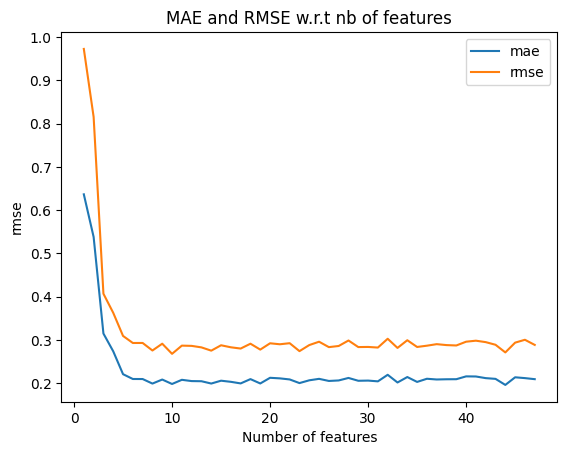

In [ ]:
def show_chart(df,metric):
    temp_1 = df[metric].tolist()
    temp_2 = list(range(1,(len(temp_1) + 1)))
    plt.xlabel("Number of features")
    plt.ylabel(metric)
    plt.title('MAE and RMSE w.r.t nb of features')
    plt.plot(temp_2, temp_1, label=metric)
    plt.savefig(f'{feature_selection_type}-accuracy.png')
    plt.legend()

show_chart(measures_df,'mae')
show_chart(measures_df,'rmse')

####**Saved Models**

**XGB**

In [ ]:
params_xgb ={'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8,
       'reg_alpha':0.5,'reg_lambda':0.5,'gamma':0.2}
selected_features_xgb=['Lightpath Lengths', 'Modulation Format Level',
       'Max Spans Lengths', 'Mean Spans Lengths', 'STD Spans Lengths',
       'Max Links Lengths', 'Mean Links Lengths',
       'Ligthpath Total Traffic Load', 'Root Mean Square Link Powers']
train_prepared_model (selected_features_xgb,params_xgb,'xgb',f'Another RFA for XGB')

total_splits: 7403


,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,PowerShap for XGB,0.279000,0.205000,0.998000,9,1.859238,0.554000,9.433000,0.490000,3169.0
1,PowerShap for CatBoost,0.278000,0.202000,0.998000,19,7.066689,0.794000,39.769000,0.385000,3000.0
2,PowerShap for LGB,0.277000,0.203000,0.998000,11,1.233359,0.731000,11.719000,0.533000,16097.0
3,Boruta for XGB,0.280000,0.206000,0.998000,13,4.004735,0.562000,10.639000,0.491000,3279.0
4,RFE for XGB,0.278000,0.205000,0.998000,12,4.361500,0.817000,40.776000,0.499000,7349.0
5,RFA for XGB,0.285000,0.209000,0.998000,27,7.097307,0.730000,36.031000,0.494000,7257.0
6,Boruta for XGB,0.280000,0.206000,0.998000,13,2.775791,0.562000,9.206000,0.492000,3279.0
7,RFE for XGB,0.278000,0.205000,0.998000,12,4.405652,0.556000,10.319000,0.491000,7349.0
8,RFA for XGB,0.285000,0.209000,0.998000,27,6.251560,0.574000,5.741000,0.499000,7257.0
9,Boruta for LGB,0.280000,0.205000,0.998000,13,1.124921,0.709000,30.602000,0.532000,14298.0


**LGB**

In [ ]:
params_lgb = {'learning_rate': 0.05, 'max_depth': 6, 'min_child_samples': 10, 'n_estimators': 500, "num_leaves" : 34}
selected_features_lgb=[
    "Lightpath Lengths",
    "Modulation Format Level",
    "Max Spans Lengths",
    "Mean Spans Lengths",
    "STD Spans Lengths",
    "Max Links Lengths",
    "Mean Links Lengths",
    "Ligthpath Total Traffic Load",
    "Min Spans Lengths",
    "Mean Right Hand Links Traffic Load",
    "Root Mean Square Link Powers",
    "Min Links Lengths",
    "Channel Under Test Position",
    "STD Links Lengths"
]
train_prepared_model (selected_features_lgb,params_lgb,'lgb',f'Another RFA for LGB')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 7675, number of used features: 14
[LightGBM] [Info] Start training from score 15.589584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,PowerShap for XGB,0.279,0.205,0.998,9,1.859238,0.554,9.433,0.490,3169
1,PowerShap for CatBoost,0.278,0.202,0.998,19,7.066689,0.794,39.769,0.385,3000
2,PowerShap for LGB,0.277,0.203,0.998,11,1.233359,0.731,11.719,0.533,16097
3,Boruta for XGB,0.280,0.206,0.998,13,4.004735,0.562,10.639,0.491,3279
4,RFE for XGB,0.278,0.205,0.998,12,4.361500,0.817,40.776,0.499,7349
5,RFA for XGB,0.285,0.209,0.998,27,7.097307,0.730,36.031,0.494,7257
6,Boruta for XGB,0.280,0.206,0.998,13,2.775791,0.562,9.206,0.492,3279
7,RFE for XGB,0.278,0.205,0.998,12,4.405652,0.556,10.319,0.491,7349
8,RFA for XGB,0.285,0.209,0.998,27,6.251560,0.574,5.741,0.499,7257
9,Boruta for LGB,0.280,0.205,0.998,13,1.124921,0.709,30.602,0.532,14298


**CB**

In [ ]:
params_cb = {}
selected_features_cb=["Lightpath Lengths",
    "Modulation Format Level",
    "Lightpath Span Number",
    "Max Spans Lengths",
    "Max Links Lengths",
    "Mean Spans Lengths",
    "Link Number",
    "Mean Links Lengths",
    "Max Link Powers",
    "STD Spans Lengths",
    "Mean Link Powers",
    "STD Right Hand Likns Traffic Load",
    "Mean Span Number per Link",
    "STD Left Hand Links Idle Neighbours",
    "Max Span Number per Link",
    "Ligthpath Total Traffic Load",
    "Max Left Hand Links Idle Neighbours",
    "Min Link Powers",
    "Root Mean Square Link Powers",
    "STD Right Hand Links Idle Neighbours"]
train_prepared_model (selected_features_cb,params_cb,'cbr',f'Another RFA for CatBoost')

Learning rate set to 0.056497
0:	learn: 5.9418842	total: 5.71ms	remaining: 5.71s
1:	learn: 5.6282705	total: 10.3ms	remaining: 5.13s
2:	learn: 5.3339977	total: 14.3ms	remaining: 4.74s
3:	learn: 5.0547369	total: 18.1ms	remaining: 4.52s
4:	learn: 4.7970014	total: 22.5ms	remaining: 4.47s
5:	learn: 4.5498247	total: 27.1ms	remaining: 4.49s
6:	learn: 4.3151204	total: 31.3ms	remaining: 4.45s
7:	learn: 4.0962169	total: 35.5ms	remaining: 4.41s
8:	learn: 3.8880680	total: 39.6ms	remaining: 4.37s
9:	learn: 3.6911798	total: 43.7ms	remaining: 4.32s
10:	learn: 3.5028794	total: 47.7ms	remaining: 4.29s
11:	learn: 3.3224124	total: 51.6ms	remaining: 4.25s
12:	learn: 3.1575034	total: 55.4ms	remaining: 4.2s
13:	learn: 2.9978307	total: 59.2ms	remaining: 4.17s
14:	learn: 2.8482135	total: 63.2ms	remaining: 4.15s
15:	learn: 2.7064495	total: 67ms	remaining: 4.12s
16:	learn: 2.5753269	total: 70.7ms	remaining: 4.09s
17:	learn: 2.4458860	total: 74.9ms	remaining: 4.08s
18:	learn: 2.3237046	total: 78.9ms	remaining: 4

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms),nb of splits
0,PowerShap for XGB,0.279,0.205,0.998,9,1.859238,0.554,9.433,0.490,3169
1,PowerShap for CatBoost,0.278,0.202,0.998,19,7.066689,0.794,39.769,0.385,3000
2,PowerShap for LGB,0.277,0.203,0.998,11,1.233359,0.731,11.719,0.533,16097
3,Boruta for XGB,0.280,0.206,0.998,13,4.004735,0.562,10.639,0.491,3279
4,RFE for XGB,0.278,0.205,0.998,12,4.361500,0.817,40.776,0.499,7349
5,RFA for XGB,0.285,0.209,0.998,27,7.097307,0.730,36.031,0.494,7257
6,Boruta for XGB,0.280,0.206,0.998,13,2.775791,0.562,9.206,0.492,3279
7,RFE for XGB,0.278,0.205,0.998,12,4.405652,0.556,10.319,0.491,7349
8,RFA for XGB,0.285,0.209,0.998,27,6.251560,0.574,5.741,0.499,7257
9,Boruta for LGB,0.280,0.205,0.998,13,1.124921,0.709,30.602,0.532,14298


##**Method 4: Top K according to Shap Values**

In [ ]:
feature_importance = np.abs(shap_values).mean(axis=0)

# Select top-k features
k = 9
top_k_indices = np.argsort(feature_importance)[-k:]
selected_features = X_train.columns[top_k_indices]

train_selected_features(selected_features,f'Top K={k}',model=feature_selection_type)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1643
[LightGBM] [Info] Number of data points in the train set: 7675, number of used features: 9
[LightGBM] [Info] Start training from score 15.589584


,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms)
0,XGB Regressor,0.307,0.227,0.997,47,9.946146,4.217,88.905,0.533
1,XGB after tuning,0.307,0.224,0.997,47,17.582744,0.733,10.368,0.631
2,GB Regressor,0.345,0.260,0.997,47,6.429242,0.165,1.174,0.141
3,GB Regressor with tuning,0.303,0.222,0.998,47,20.130394,0.664,6.365,0.357
4,HGB Regressor,0.293,0.217,0.998,47,1.019729,1.807,1250.407,1.451
5,HGB with tuning,0.289,0.215,0.998,47,6.831256,7.262,1410.803,5.418
6,LGB Regressor,0.295,0.218,0.998,47,1.032871,0.643,3.348,0.537
7,CAT Boost Regressor,0.279,0.204,0.998,47,11.483410,0.604,3.058,0.471
8,Feature Selection method: Another RFA,0.293,0.212,0.998,11,23.686383,1.324,40.682,0.632
9,Feature Selection method: Another RFA,0.293,0.212,0.998,11,6.621957,0.733,9.622,0.625


##**Method 5: RFECV** (not shap related)

* ShapRFECV not supported for regression

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

In [ ]:
model = XGBRegressor(learning_rate=0.1, subsample=0.3, n_estimators=500)
rfecv = RFECV(estimator=model)

pipeline = Pipeline(steps=[('s',rfecv),('m',model)])
pipeline.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

print(selected_features)
train_selected_features(selected_features,f'RFECV')


In [ ]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()
rfecv.cv_results_

###**SHAPRFECV** ValueError: continuous format is not supported


In [ ]:
!pip install probatus
from probatus.feature_elimination import ShapRFECV


In [ ]:
shap_elimination = ShapRFECV(
    clf=xgb, step=0.2, cv=5,  n_jobs=3)
report = shap_elimination.fit_compute(X_train, y_train)
# Make plots
performance_plot = shap_elimination.plot()

# Get final feature set
final_features_set = shap_elimination.get_reduced_features_set(num_features=3)

#**Results and Selected Features**

##**Using XGB**

In [ ]:
get_features()

,Feature_Selection_Method,Nb_Features,Selected_Features
0,PowerShap,8,"Modulation Format Level, Mean Spans Lengths, M..."
1,Boruta,12,"Modulation Format Level, Mean Spans Lengths, M..."
2,RFE,10,"Modulation Format Level, Mean Spans Lengths, M..."
3,RFA,31,"Modulation Format Level, Link Number, Mean Spa..."
4,Another RFA Approach,10,"Lightpath Lengths, Modulation Format Level, Ma..."
5,Top K=11,11,"Root Mean Square Link Powers, Min Spans Length..."
6,RFECV,11,"Modulation Format Level, Mean Spans Lengths, M..."


In [ ]:
get_results() #using XGB

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms)
0,Farhad Results,0.307000,0.224000,0.997000,47,10.737699,0.782000,37.770000,0.533000
1,XGB Regressor with tuning,0.283000,0.210000,0.998000,47,10.528722,0.735000,42.696000,0.472000
2,PowerShap,0.275000,0.204000,0.998000,9,1.960803,0.617000,10.388000,0.502000
3,Boruta,0.275000,0.203000,0.998000,13,2.425601,0.591000,8.419000,0.489000
4,RFE,0.276000,0.202000,0.998000,12,3.858656,0.629000,37.602000,0.502000
5,RFA,0.282000,0.205000,0.998000,27,6.271676,0.636000,9.563000,0.507000
6,Another RFA Approach,0.264014,0.194128,0.998249,9,5.157945,0.608873,5.579233,0.514507


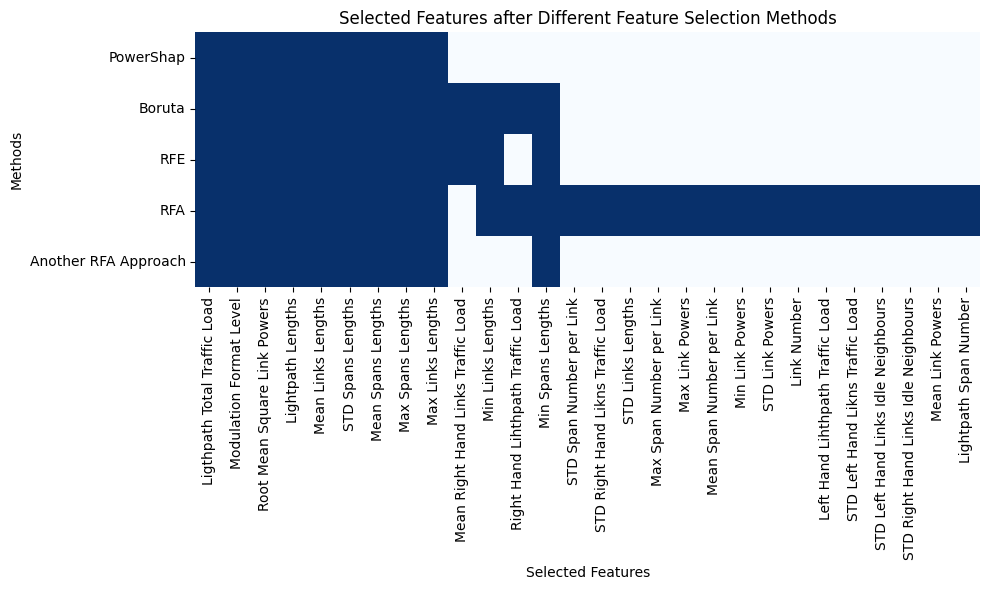

In [88]:
features_summary()

##**Using LGB**

In [ ]:
get_results() #using LGBM

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms)
0,LGB Regressor with tuning,0.281000,0.207000,0.998000,47,3.486326,0.874000,22.40000,0.579000
1,Powershap after tuning,0.275000,0.202000,0.998000,11,0.798409,0.803000,6.09000,0.562000
2,Boruta after tuning,0.280000,0.205000,0.998000,13,0.771863,0.685000,2.23800,0.560000
3,RFE after tuning,0.278000,0.203000,0.998000,9,0.606548,0.691000,3.45300,0.558000
4,RFA,0.279000,0.206000,0.998000,30,1.387273,0.727000,4.45300,0.549000
5,Another RFA Approach,0.275379,0.199066,0.998098,14,0.760090,0.824306,5.14245,0.562191


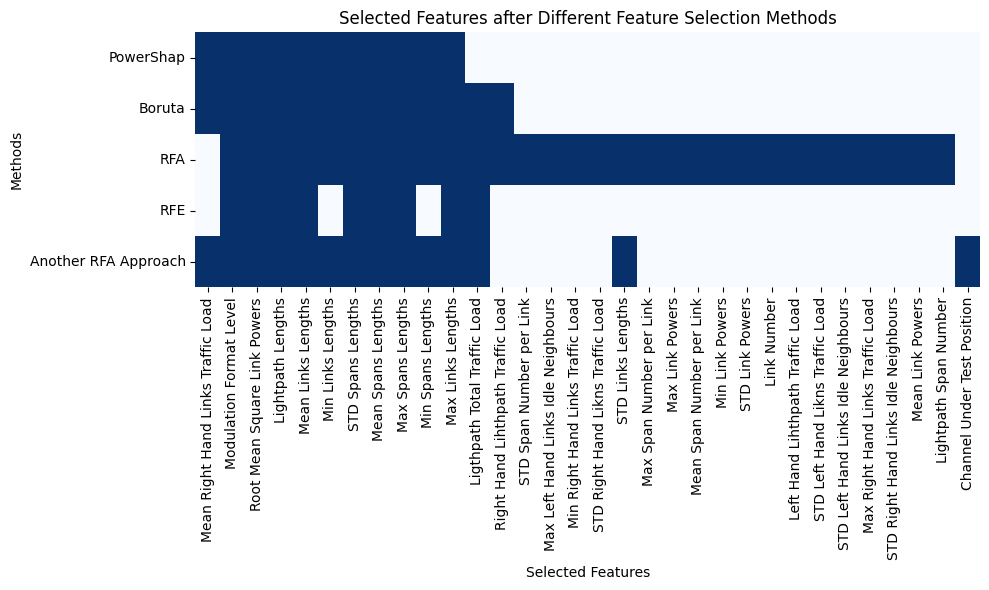

In [87]:
features_summary()

##**Catboost**

In [ ]:
get_results()

,type,rmse,mae,r2,nb_features,training time (s),average inference time/data point (ms),max inference time/data point (ms),min inference time/data point (ms)
0,CAT Boost Regressor,0.274000,0.201000,0.998000,47,9.500043,0.699000,25.915000,0.477000
1,PowerShap + Catboost Tuning,0.278000,0.202000,0.998000,19,1.118453,0.736000,36.738000,0.455000
2,Another RFA Approach,0.266666,0.198458,0.998202,21,2.122354,0.636045,4.586458,0.430822


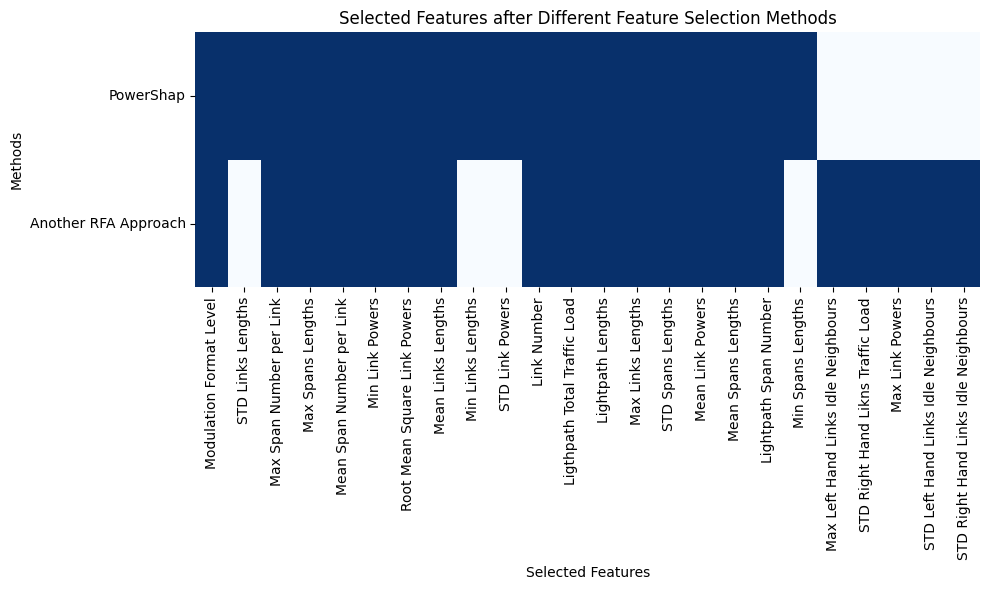

In [83]:
features_summary()